<img width="800px" src="../fidle/img/00-Fidle-header-01.svg"></img>

# <!-- TITLE --> [SYNOP2] - First predictions at 3h
<!-- DESC --> Episode 2 : Learning session and weather prediction attempt at 3h
<!-- AUTHOR : Jean-Luc Parouty (CNRS/SIMaP) -->

## Objectives :
 - Make a simple prediction (3h)
 - Understanding the use of a recurrent neural network


SYNOP meteorological data, available at: https://public.opendatasoft.com

## What we're going to do :

 - Read our dataset
 - Select our data and normalize it
 - Doing our training
 - Making simple predictions

## Step 1 - Import and init
### 1.1 - Python

In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.callbacks import TensorBoard
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator

import numpy as np
import math, random
import matplotlib.pyplot as plt

import pandas as pd
import h5py, json
import os,time,sys

from importlib import reload

sys.path.append('..')
import fidle.pwk as pwk

datasets_dir = pwk.init('SYNOP2')

<br>**FIDLE 2020 - Practical Work Module**

Version              : 2.0.7
Notebook id          : SYNOP2
Run time             : Wednesday 27 January 2021, 19:20:11
TensorFlow version   : 2.2.0
Keras version        : 2.3.0-tf
Datasets dir         : /gpfswork/rech/mlh/uja62cb/datasets
Run dir              : ./run
Update keras cache   : False
Save figs            : True
Path figs            : ./run/figs


### 1.2 - Parameters

In [2]:
# ---- About dataset
#
dataset_dir      = './data'
dataset_filename = 'synop-LYS.csv'
schema_filename  = 'synop.json'
features         = ['tend', 'cod_tend', 'dd', 'ff', 'td', 'u', 'ww', 'pres', 'rafper', 'rr1', 'rr3', 'tc']
features_len     = len(features)

# ---- About training
#
scale            = 1        # Percentage of dataset to be used (1=all)
train_prop       = .8       # Percentage for train (the rest being for the test)
sequence_len     = 16
batch_size       = 32
epochs           = 10

Override parameters (batch mode) - Just forget this cell

In [3]:
pwk.override('scale', 'train_prop', 'sequence_len', 'batch_size', 'epochs')

**\*\* Overrided parameters : \*\***

scale                : 1
train_prop           : 0.8
sequence_len         : 16
batch_size           : 32
epochs               : 10


## Step 2 - Read and prepare dataset
### 2.1 - Read it

In [4]:
# ---- Read dataset from ./data

df = pd.read_csv(f'{dataset_dir}/{dataset_filename}', header=0, sep=';')

# ---- Scaling

df = df[:int(scale*len(df))]
train_len=int(train_prop*len(df))

# ---- Train / Test
dataset_train = df.loc[ :train_len-1, features ]
dataset_test  = df.loc[train_len:,    features ]
pwk.subtitle('Train dataset example :')
display(dataset_train.head(15))

# ---- Normalize, and convert to numpy array

mean = dataset_train.mean()
std  = dataset_train.std()
dataset_train = (dataset_train - mean) / std
dataset_test  = (dataset_test  - mean) / std

pwk.subtitle('After normalization :')
display(dataset_train.describe().style.format("{0:.2f}"))

dataset_train = dataset_train.to_numpy()
dataset_test  = dataset_test.to_numpy()

pwk.subtitle('Shapes :')
print('Dataset       : ',df.shape)
print('Train dataset : ',dataset_train.shape)
print('Test  dataset : ',dataset_test.shape)


<br>**Train dataset example :**

,tend,cod_tend,dd,ff,td,u,ww,pres,rafper,rr1,rr3,tc
0,-120.0,6.0,0.0,0.0,278.75,88.0,60.0,96250.0,4.1,0.0,0.0,7.5
1,-150.0,6.0,60.0,1.0,278.65,93.0,61.0,96100.0,2.6,0.2,0.6,6.6
2,10.0,3.0,280.0,2.1,278.85,95.0,58.0,96110.0,2.6,0.0,0.4,6.4
3,230.0,3.0,310.0,2.6,279.15,96.0,50.0,96340.0,5.7,0.0,3.0,6.6
4,280.0,1.0,330.0,4.6,278.15,94.0,21.0,96620.0,8.7,0.4,0.8,5.9
5,480.0,3.0,350.0,5.1,276.95,91.0,60.0,97100.0,8.2,0.2,0.4,5.2
6,530.0,2.0,350.0,3.1,274.05,83.0,21.0,97630.0,7.2,0.0,0.0,3.5
7,450.0,2.0,340.0,6.2,272.15,81.0,2.0,98080.0,9.3,0.0,0.0,1.9
8,280.0,1.0,320.0,6.2,270.15,74.0,2.0,98360.0,10.3,0.0,0.0,1.1
9,220.0,1.0,290.0,2.6,269.65,72.0,2.0,98580.0,5.1,0.0,0.0,1.0


<br>**After normalization :**

,tend,cod_tend,dd,ff,td,u,ww,pres,rafper,rr1,rr3,tc
count,23332.00,23332.00,23332.00,23332.00,23332.00,23332.00,23332.00,23332.00,23332.00,23332.00,23332.00,23332.00
mean,0.00,0.00,-0.00,0.00,0.00,0.00,0.00,-0.00,-0.00,-0.00,0.00,-0.00
std,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00
min,-6.79,-1.59,-1.74,-1.36,-5.22,-3.85,-0.53,-4.97,-1.62,-0.32,-0.27,-3.04
25%,-0.63,-0.85,-0.62,-0.75,-0.72,-0.68,-0.42,-0.55,-0.69,-0.16,-0.20,-0.75
50%,-0.00,-0.48,-0.11,-0.19,0.04,0.21,-0.42,0.04,-0.29,-0.16,-0.20,-0.01
75%,0.63,0.99,1.10,0.50,0.77,0.82,-0.37,0.62,0.51,-0.16,-0.20,0.71
max,7.14,1.36,1.35,6.24,2.44,1.59,4.45,3.08,6.25,29.82,31.17,3.07


<br>**Shapes :**

Dataset       :  (29165, 14)
Train dataset :  (23332, 12)
Test  dataset :  (5833, 12)


### 2.2 - Prepare data generator

In [5]:
# ---- Train generator
train_generator = TimeseriesGenerator(dataset_train, dataset_train, length=sequence_len,  batch_size=batch_size)
test_generator  = TimeseriesGenerator(dataset_test,  dataset_test,  length=sequence_len,  batch_size=batch_size)

# ---- About

pwk.subtitle('About the splitting of our dataset :')

x,y=train_generator[0]
print(f'Nombre de train batchs disponibles : ', len(train_generator))
print('batch x shape : ',x.shape)
print('batch y shape : ',y.shape)

x,y=train_generator[0]
pwk.subtitle('What a batch looks like (x) :')
pwk.np_print(x[0] )
pwk.subtitle('What a batch looks like (y) :')
pwk.np_print(y[0])

<br>**About the splitting of our dataset :**

Nombre de train batchs disponibles :  729
batch x shape :  (32, 16, 12)
batch y shape :  (32, 12)


<br>**What a batch looks like (x) :**

[[-1.087  0.623 -1.743 -1.361 -0.212  0.928  2.554 -3.533 -0.555 -0.156 -0.199 -0.624]
 [-1.358  0.623 -1.227 -0.957 -0.229  1.206  2.605 -3.733 -0.946  0.17   0.219 -0.735]
 [ 0.089 -0.482  0.666 -0.512 -0.195  1.317  2.451 -3.72  -0.946 -0.156  0.08  -0.76 ]
 [ 2.079 -0.482  0.924 -0.31  -0.144  1.372  2.04  -3.413 -0.137 -0.156  1.892 -0.735]
 [ 2.531 -1.219  1.096  0.499 -0.313  1.261  0.552 -3.04   0.645  0.495  0.358 -0.821]
 [ 4.34  -0.482  1.268  0.701 -0.517  1.095  2.554 -2.401  0.515  0.17   0.08  -0.907]
 [ 4.792 -0.85   1.268 -0.107 -1.01   0.65   0.552 -1.694  0.254 -0.156 -0.199 -1.117]
 [ 4.069 -0.85   1.182  1.146 -1.333  0.539 -0.424 -1.094  0.802 -0.156 -0.199 -1.314]
 [ 2.531 -1.219  1.01   1.146 -1.673  0.15  -0.424 -0.721  1.063 -0.156 -0.199 -1.412]
 [ 1.988 -1.219  0.752 -0.31  -1.758  0.039 -0.424 -0.428 -0.294 -0.156 -0.199 -1.425]
 [ 0.903 -1.219  1.268 -0.107 -1.622  0.428 -0.424 -0.295 -0.555 -0.156 -0.199 -1.486]
 [ 2.712 -0.482  1.268  0.701 -1.944 -0.072

<br>**What a batch looks like (y) :**

[ 0.179 -1.219  0.58  -0.755 -2.063  0.65  -0.424  0.665 -1.233 -0.156 -0.199 -1.93 ]


## Step 3 - Create a model

In [6]:
model = keras.models.Sequential()
model.add( keras.layers.InputLayer(input_shape=(sequence_len, features_len)) )
model.add( keras.layers.LSTM(100, activation='relu') )
model.add( keras.layers.Dropout(0.2) )
model.add( keras.layers.Dense(features_len) )

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 100)               45200     
_________________________________________________________________
dropout (Dropout)            (None, 100)               0         
_________________________________________________________________
dense (Dense)                (None, 12)                1212      
Total params: 46,412
Trainable params: 46,412
Non-trainable params: 0
_________________________________________________________________


# Step 4 - Compile and run

### 4.1 - Callback

In [7]:
pwk.mkdir('./run/models')
save_dir = './run/models/best_model.h5'
bestmodel_callback = tf.keras.callbacks.ModelCheckpoint(filepath=save_dir, verbose=0, save_best_only=True)

### 4.2 - Compile

In [8]:
model.compile(optimizer='adam', 
              loss='mse', 
              metrics   = ['mae'] )

### 4.3 - Fit
6' with a CPU (laptop)  
2' with a GPU

In [9]:
pwk.chrono_start()

history=model.fit(train_generator, 
                  epochs=epochs, 
                  verbose=1,
                  validation_data = test_generator,
                  callbacks = [bestmodel_callback])

pwk.chrono_show()

Epoch 1/10


  1/729 [..............................] - ETA: 0s - loss: 1.0393 - mae: 0.7576

  5/729 [..............................] - ETA: 8s - loss: 1.0467 - mae: 0.7401

  9/729 [..............................] - ETA: 9s - loss: 1.0316 - mae: 0.7201

 13/729 [..............................] - ETA: 9s - loss: 0.9848 - mae: 0.7269

 17/729 [..............................] - ETA: 9s - loss: 0.9073 - mae: 0.7027

 21/729 [..............................] - ETA: 10s - loss: 0.9292 - mae: 0.7183

 25/729 [>.............................] - ETA: 10s - loss: 0.9404 - mae: 0.7225

 29/729 [>.............................] - ETA: 10s - loss: 0.9152 - mae: 0.7151

 33/729 [>.............................] - ETA: 10s - loss: 0.9102 - mae: 0.7171

 37/729 [>.............................] - ETA: 9s - loss: 0.8833 - mae: 0.7046 

 41/729 [>.............................] - ETA: 9s - loss: 0.8941 - mae: 0.6977

 45/729 [>.............................] - ETA: 9s - loss: 0.9090 - mae: 0.6909

 49/729 [=>............................] - ETA: 9s - loss: 0.8893 - mae: 0.6846

 53/729 [=>............................] - ETA: 9s - loss: 0.8805 - mae: 0.6764

 57/729 [=>............................] - ETA: 9s - loss: 0.8591 - mae: 0.6680

 61/729 [=>............................] - ETA: 9s - loss: 0.8359 - mae: 0.6588

 65/729 [=>............................] - ETA: 9s - loss: 0.8299 - mae: 0.6566

 69/729 [=>............................] - ETA: 9s - loss: 0.8162 - mae: 0.6515

 73/729 [==>...........................] - ETA: 9s - loss: 0.8228 - mae: 0.6498

 77/729 [==>...........................] - ETA: 9s - loss: 0.8099 - mae: 0.6441

 81/729 [==>...........................] - ETA: 9s - loss: 0.8372 - mae: 0.6411

 85/729 [==>...........................] - ETA: 9s - loss: 0.8308 - mae: 0.6393

 89/729 [==>...........................] - ETA: 9s - loss: 0.8264 - mae: 0.6375

 93/729 [==>...........................] - ETA: 9s - loss: 0.8169 - mae: 0.6342

 97/729 [==>...........................] - ETA: 9s - loss: 0.8271 - mae: 0.6337

101/729 [===>..........................] - ETA: 9s - loss: 0.8235 - mae: 0.6316

105/729 [===>..........................] - ETA: 9s - loss: 0.8159 - mae: 0.6288

109/729 [===>..........................] - ETA: 9s - loss: 0.8127 - mae: 0.6280

113/729 [===>..........................] - ETA: 8s - loss: 0.8052 - mae: 0.6263

117/729 [===>..........................] - ETA: 8s - loss: 0.8056 - mae: 0.6269

121/729 [===>..........................] - ETA: 8s - loss: 0.8033 - mae: 0.6247

125/729 [====>.........................] - ETA: 8s - loss: 0.7978 - mae: 0.6207

129/729 [====>.........................] - ETA: 8s - loss: 0.7962 - mae: 0.6194

133/729 [====>.........................] - ETA: 8s - loss: 0.7927 - mae: 0.6185

137/729 [====>.........................] - ETA: 8s - loss: 0.7845 - mae: 0.6160

141/729 [====>.........................] - ETA: 8s - loss: 0.7867 - mae: 0.6158

145/729 [====>.........................] - ETA: 8s - loss: 0.7805 - mae: 0.6136

149/729 [=====>........................] - ETA: 8s - loss: 0.7760 - mae: 0.6121

153/729 [=====>........................] - ETA: 8s - loss: 0.7723 - mae: 0.6107

157/729 [=====>........................] - ETA: 8s - loss: 0.7649 - mae: 0.6081

161/729 [=====>........................] - ETA: 8s - loss: 0.7595 - mae: 0.6065

165/729 [=====>........................] - ETA: 8s - loss: 0.7535 - mae: 0.6042

169/729 [=====>........................] - ETA: 8s - loss: 0.7492 - mae: 0.6024

173/729 [======>.......................] - ETA: 8s - loss: 0.7445 - mae: 0.6009

177/729 [======>.......................] - ETA: 8s - loss: 0.7446 - mae: 0.6000

181/729 [======>.......................] - ETA: 8s - loss: 0.7415 - mae: 0.5989

185/729 [======>.......................] - ETA: 7s - loss: 0.7380 - mae: 0.5976

189/729 [======>.......................] - ETA: 7s - loss: 0.7334 - mae: 0.5955

193/729 [======>.......................] - ETA: 7s - loss: 0.7305 - mae: 0.5941

197/729 [=======>......................] - ETA: 7s - loss: 0.7281 - mae: 0.5935

201/729 [=======>......................] - ETA: 7s - loss: 0.7261 - mae: 0.5922

205/729 [=======>......................] - ETA: 7s - loss: 0.7266 - mae: 0.5926

209/729 [=======>......................] - ETA: 7s - loss: 0.7244 - mae: 0.5919

213/729 [=======>......................] - ETA: 7s - loss: 0.7186 - mae: 0.5897

217/729 [=======>......................] - ETA: 7s - loss: 0.7184 - mae: 0.5890

221/729 [========>.....................] - ETA: 7s - loss: 0.7216 - mae: 0.5887

225/729 [========>.....................] - ETA: 7s - loss: 0.7199 - mae: 0.5881

229/729 [========>.....................] - ETA: 7s - loss: 0.7156 - mae: 0.5866

233/729 [========>.....................] - ETA: 7s - loss: 0.7130 - mae: 0.5853

237/729 [========>.....................] - ETA: 7s - loss: 0.7097 - mae: 0.5844

241/729 [========>.....................] - ETA: 7s - loss: 0.7086 - mae: 0.5836

245/729 [=========>....................] - ETA: 7s - loss: 0.7061 - mae: 0.5826

249/729 [=========>....................] - ETA: 7s - loss: 0.7024 - mae: 0.5812

253/729 [=========>....................] - ETA: 6s - loss: 0.7003 - mae: 0.5803

257/729 [=========>....................] - ETA: 6s - loss: 0.7069 - mae: 0.5791

261/729 [=========>....................] - ETA: 6s - loss: 0.7133 - mae: 0.5790

265/729 [=========>....................] - ETA: 6s - loss: 0.7095 - mae: 0.5775

269/729 [==========>...................] - ETA: 6s - loss: 0.7064 - mae: 0.5763

273/729 [==========>...................] - ETA: 6s - loss: 0.7032 - mae: 0.5752

277/729 [==========>...................] - ETA: 6s - loss: 0.7105 - mae: 0.5762

281/729 [==========>...................] - ETA: 6s - loss: 0.7065 - mae: 0.5746

285/729 [==========>...................] - ETA: 6s - loss: 0.7084 - mae: 0.5748

289/729 [==========>...................] - ETA: 6s - loss: 0.7058 - mae: 0.5735

293/729 [===========>..................] - ETA: 6s - loss: 0.7027 - mae: 0.5725

297/729 [===========>..................] - ETA: 6s - loss: 0.6996 - mae: 0.5715

301/729 [===========>..................] - ETA: 6s - loss: 0.6972 - mae: 0.5709

305/729 [===========>..................] - ETA: 6s - loss: 0.6933 - mae: 0.5695

309/729 [===========>..................] - ETA: 6s - loss: 0.6960 - mae: 0.5687

313/729 [===========>..................] - ETA: 6s - loss: 0.6943 - mae: 0.5683

317/729 [============>.................] - ETA: 6s - loss: 0.6984 - mae: 0.5678

321/729 [============>.................] - ETA: 5s - loss: 0.6979 - mae: 0.5674

325/729 [============>.................] - ETA: 5s - loss: 0.6972 - mae: 0.5666

329/729 [============>.................] - ETA: 5s - loss: 0.6971 - mae: 0.5664

333/729 [============>.................] - ETA: 5s - loss: 0.6990 - mae: 0.5662

337/729 [============>.................] - ETA: 5s - loss: 0.6961 - mae: 0.5654

341/729 [=============>................] - ETA: 5s - loss: 0.6932 - mae: 0.5645

345/729 [=============>................] - ETA: 5s - loss: 0.6899 - mae: 0.5632

349/729 [=============>................] - ETA: 5s - loss: 0.6974 - mae: 0.5636

353/729 [=============>................] - ETA: 5s - loss: 0.6940 - mae: 0.5624

357/729 [=============>................] - ETA: 5s - loss: 0.6917 - mae: 0.5612

361/729 [=============>................] - ETA: 5s - loss: 0.6886 - mae: 0.5601

365/729 [==============>...............] - ETA: 5s - loss: 0.6863 - mae: 0.5594

369/729 [==============>...............] - ETA: 5s - loss: 0.6844 - mae: 0.5587

373/729 [==============>...............] - ETA: 5s - loss: 0.6813 - mae: 0.5575

377/729 [==============>...............] - ETA: 5s - loss: 0.6823 - mae: 0.5570

381/729 [==============>...............] - ETA: 5s - loss: 0.6794 - mae: 0.5558

385/729 [==============>...............] - ETA: 5s - loss: 0.6811 - mae: 0.5555

389/729 [===============>..............] - ETA: 4s - loss: 0.6784 - mae: 0.5544

393/729 [===============>..............] - ETA: 4s - loss: 0.6789 - mae: 0.5536

397/729 [===============>..............] - ETA: 4s - loss: 0.6756 - mae: 0.5524

401/729 [===============>..............] - ETA: 4s - loss: 0.6734 - mae: 0.5518

405/729 [===============>..............] - ETA: 4s - loss: 0.6717 - mae: 0.5511

409/729 [===============>..............] - ETA: 4s - loss: 0.6777 - mae: 0.5509

413/729 [===============>..............] - ETA: 4s - loss: 0.6816 - mae: 0.5509

417/729 [================>.............] - ETA: 4s - loss: 0.6806 - mae: 0.5504

421/729 [================>.............] - ETA: 4s - loss: 0.6788 - mae: 0.5500

425/729 [================>.............] - ETA: 4s - loss: 0.6776 - mae: 0.5497

429/729 [================>.............] - ETA: 4s - loss: 0.6762 - mae: 0.5493

433/729 [================>.............] - ETA: 4s - loss: 0.6753 - mae: 0.5486

437/729 [================>.............] - ETA: 4s - loss: 0.6729 - mae: 0.5476

441/729 [=================>............] - ETA: 4s - loss: 0.6727 - mae: 0.5471

445/729 [=================>............] - ETA: 4s - loss: 0.6703 - mae: 0.5462

449/729 [=================>............] - ETA: 4s - loss: 0.6698 - mae: 0.5460

453/729 [=================>............] - ETA: 4s - loss: 0.6681 - mae: 0.5453

457/729 [=================>............] - ETA: 3s - loss: 0.6666 - mae: 0.5447

461/729 [=================>............] - ETA: 3s - loss: 0.6655 - mae: 0.5444

465/729 [==================>...........] - ETA: 3s - loss: 0.6631 - mae: 0.5435

469/729 [==================>...........] - ETA: 3s - loss: 0.6623 - mae: 0.5431

473/729 [==================>...........] - ETA: 3s - loss: 0.6632 - mae: 0.5428

477/729 [==================>...........] - ETA: 3s - loss: 0.6626 - mae: 0.5424

481/729 [==================>...........] - ETA: 3s - loss: 0.6627 - mae: 0.5422

485/729 [==================>...........] - ETA: 3s - loss: 0.6612 - mae: 0.5416

489/729 [===================>..........] - ETA: 3s - loss: 0.6584 - mae: 0.5405

493/729 [===================>..........] - ETA: 3s - loss: 0.6570 - mae: 0.5400

497/729 [===================>..........] - ETA: 3s - loss: 0.6557 - mae: 0.5394

501/729 [===================>..........] - ETA: 3s - loss: 0.6549 - mae: 0.5388

505/729 [===================>..........] - ETA: 3s - loss: 0.6532 - mae: 0.5381

509/729 [===================>..........] - ETA: 3s - loss: 0.6523 - mae: 0.5378

513/729 [====================>.........] - ETA: 3s - loss: 0.6509 - mae: 0.5373

517/729 [====================>.........] - ETA: 3s - loss: 0.6497 - mae: 0.5368

521/729 [====================>.........] - ETA: 3s - loss: 0.6560 - mae: 0.5365

525/729 [====================>.........] - ETA: 3s - loss: 0.6545 - mae: 0.5358

529/729 [====================>.........] - ETA: 2s - loss: 0.6534 - mae: 0.5355

533/729 [====================>.........] - ETA: 2s - loss: 0.6513 - mae: 0.5348

537/729 [=====================>........] - ETA: 2s - loss: 0.6493 - mae: 0.5340

541/729 [=====================>........] - ETA: 2s - loss: 0.6497 - mae: 0.5337

545/729 [=====================>........] - ETA: 2s - loss: 0.6479 - mae: 0.5329

549/729 [=====================>........] - ETA: 2s - loss: 0.6463 - mae: 0.5323

553/729 [=====================>........] - ETA: 2s - loss: 0.6485 - mae: 0.5319

557/729 [=====================>........] - ETA: 2s - loss: 0.6477 - mae: 0.5316

561/729 [======================>.......] - ETA: 2s - loss: 0.6462 - mae: 0.5311

565/729 [======================>.......] - ETA: 2s - loss: 0.6469 - mae: 0.5312

569/729 [======================>.......] - ETA: 2s - loss: 0.6458 - mae: 0.5308

573/729 [======================>.......] - ETA: 2s - loss: 0.6448 - mae: 0.5305

577/729 [======================>.......] - ETA: 2s - loss: 0.6437 - mae: 0.5301

581/729 [======================>.......] - ETA: 2s - loss: 0.6424 - mae: 0.5296

585/729 [=======================>......] - ETA: 2s - loss: 0.6413 - mae: 0.5292

589/729 [=======================>......] - ETA: 2s - loss: 0.6408 - mae: 0.5290

593/729 [=======================>......] - ETA: 2s - loss: 0.6398 - mae: 0.5286

597/729 [=======================>......] - ETA: 1s - loss: 0.6393 - mae: 0.5284

601/729 [=======================>......] - ETA: 1s - loss: 0.6381 - mae: 0.5280

605/729 [=======================>......] - ETA: 1s - loss: 0.6371 - mae: 0.5278

609/729 [========================>.....] - ETA: 1s - loss: 0.6384 - mae: 0.5274

613/729 [========================>.....] - ETA: 1s - loss: 0.6377 - mae: 0.5272

617/729 [========================>.....] - ETA: 1s - loss: 0.6411 - mae: 0.5274

621/729 [========================>.....] - ETA: 1s - loss: 0.6397 - mae: 0.5269

625/729 [========================>.....] - ETA: 1s - loss: 0.6393 - mae: 0.5267

629/729 [========================>.....] - ETA: 1s - loss: 0.6375 - mae: 0.5260

633/729 [=========================>....] - ETA: 1s - loss: 0.6364 - mae: 0.5257

637/729 [=========================>....] - ETA: 1s - loss: 0.6350 - mae: 0.5252

641/729 [=========================>....] - ETA: 1s - loss: 0.6340 - mae: 0.5248

645/729 [=========================>....] - ETA: 1s - loss: 0.6335 - mae: 0.5244

649/729 [=========================>....] - ETA: 1s - loss: 0.6318 - mae: 0.5239

653/729 [=========================>....] - ETA: 1s - loss: 0.6304 - mae: 0.5234

657/729 [==========================>...] - ETA: 1s - loss: 0.6305 - mae: 0.5234

661/729 [==========================>...] - ETA: 1s - loss: 0.6298 - mae: 0.5232

665/729 [==========================>...] - ETA: 0s - loss: 0.6282 - mae: 0.5226

669/729 [==========================>...] - ETA: 0s - loss: 0.6269 - mae: 0.5222

673/729 [==========================>...] - ETA: 0s - loss: 0.6261 - mae: 0.5218

677/729 [==========================>...] - ETA: 0s - loss: 0.6259 - mae: 0.5214

681/729 [===========================>..] - ETA: 0s - loss: 0.6247 - mae: 0.5208

685/729 [===========================>..] - ETA: 0s - loss: 0.6236 - mae: 0.5204

689/729 [===========================>..] - ETA: 0s - loss: 0.6227 - mae: 0.5202

693/729 [===========================>..] - ETA: 0s - loss: 0.6211 - mae: 0.5196

697/729 [===========================>..] - ETA: 0s - loss: 0.6205 - mae: 0.5193

701/729 [===========================>..] - ETA: 0s - loss: 0.6195 - mae: 0.5191

705/729 [============================>.] - ETA: 0s - loss: 0.6187 - mae: 0.5187

709/729 [============================>.] - ETA: 0s - loss: 0.6183 - mae: 0.5184

713/729 [============================>.] - ETA: 0s - loss: 0.6170 - mae: 0.5178

717/729 [============================>.] - ETA: 0s - loss: 0.6165 - mae: 0.5175

721/729 [============================>.] - ETA: 0s - loss: 0.6158 - mae: 0.5172

725/729 [============================>.] - ETA: 0s - loss: 0.6146 - mae: 0.5168

729/729 [==============================] - ETA: 0s - loss: 0.6139 - mae: 0.5164

729/729 [==============================] - 12s 16ms/step - loss: 0.6139 - mae: 0.5164 - val_loss: 0.4950 - val_mae: 0.4372


Epoch 2/10
  1/729 [..............................] - ETA: 0s - loss: 0.6132 - mae: 0.5349

  5/729 [..............................] - ETA: 8s - loss: 0.4807 - mae: 0.4857

  9/729 [..............................] - ETA: 9s - loss: 0.4595 - mae: 0.4729

 13/729 [..............................] - ETA: 9s - loss: 0.4410 - mae: 0.4608

 17/729 [..............................] - ETA: 9s - loss: 0.4740 - mae: 0.4697

 21/729 [..............................] - ETA: 9s - loss: 0.4436 - mae: 0.4547

 25/729 [>.............................] - ETA: 9s - loss: 0.4290 - mae: 0.4488

 29/729 [>.............................] - ETA: 9s - loss: 0.4497 - mae: 0.4506

 33/729 [>.............................] - ETA: 9s - loss: 0.4939 - mae: 0.4573

 37/729 [>.............................] - ETA: 9s - loss: 0.5039 - mae: 0.4616

 41/729 [>.............................] - ETA: 9s - loss: 0.4997 - mae: 0.4628

 45/729 [>.............................] - ETA: 9s - loss: 0.5240 - mae: 0.4668

 49/729 [=>............................] - ETA: 9s - loss: 0.5126 - mae: 0.4640

 53/729 [=>............................] - ETA: 9s - loss: 0.5272 - mae: 0.4660

 57/729 [=>............................] - ETA: 9s - loss: 0.5176 - mae: 0.4635

 61/729 [=>............................] - ETA: 9s - loss: 0.5089 - mae: 0.4615

 65/729 [=>............................] - ETA: 9s - loss: 0.5046 - mae: 0.4602

 69/729 [=>............................] - ETA: 9s - loss: 0.5006 - mae: 0.4602

 73/729 [==>...........................] - ETA: 9s - loss: 0.4938 - mae: 0.4580

 77/729 [==>...........................] - ETA: 9s - loss: 0.4879 - mae: 0.4569

 81/729 [==>...........................] - ETA: 9s - loss: 0.4828 - mae: 0.4557

 85/729 [==>...........................] - ETA: 9s - loss: 0.4822 - mae: 0.4556

 89/729 [==>...........................] - ETA: 9s - loss: 0.4779 - mae: 0.4539

 93/729 [==>...........................] - ETA: 9s - loss: 0.4835 - mae: 0.4550

 97/729 [==>...........................] - ETA: 9s - loss: 0.4900 - mae: 0.4573

101/729 [===>..........................] - ETA: 9s - loss: 0.4884 - mae: 0.4573

105/729 [===>..........................] - ETA: 9s - loss: 0.5059 - mae: 0.4575

109/729 [===>..........................] - ETA: 9s - loss: 0.5045 - mae: 0.4571

113/729 [===>..........................] - ETA: 9s - loss: 0.5050 - mae: 0.4570

117/729 [===>..........................] - ETA: 8s - loss: 0.5001 - mae: 0.4558

121/729 [===>..........................] - ETA: 8s - loss: 0.4945 - mae: 0.4540

125/729 [====>.........................] - ETA: 8s - loss: 0.4904 - mae: 0.4528

129/729 [====>.........................] - ETA: 8s - loss: 0.4994 - mae: 0.4547

133/729 [====>.........................] - ETA: 8s - loss: 0.5217 - mae: 0.4565

137/729 [====>.........................] - ETA: 8s - loss: 0.5217 - mae: 0.4568

141/729 [====>.........................] - ETA: 8s - loss: 0.5238 - mae: 0.4583

145/729 [====>.........................] - ETA: 8s - loss: 0.5223 - mae: 0.4574

149/729 [=====>........................] - ETA: 8s - loss: 0.5224 - mae: 0.4571

153/729 [=====>........................] - ETA: 8s - loss: 0.5239 - mae: 0.4576

157/729 [=====>........................] - ETA: 8s - loss: 0.5248 - mae: 0.4584

161/729 [=====>........................] - ETA: 8s - loss: 0.5203 - mae: 0.4567

165/729 [=====>........................] - ETA: 8s - loss: 0.5171 - mae: 0.4558

169/729 [=====>........................] - ETA: 8s - loss: 0.5229 - mae: 0.4563

173/729 [======>.......................] - ETA: 8s - loss: 0.5184 - mae: 0.4548

177/729 [======>.......................] - ETA: 8s - loss: 0.5168 - mae: 0.4550

181/729 [======>.......................] - ETA: 8s - loss: 0.5211 - mae: 0.4556

185/729 [======>.......................] - ETA: 7s - loss: 0.5188 - mae: 0.4550

189/729 [======>.......................] - ETA: 7s - loss: 0.5162 - mae: 0.4547

193/729 [======>.......................] - ETA: 7s - loss: 0.5173 - mae: 0.4551

197/729 [=======>......................] - ETA: 7s - loss: 0.5191 - mae: 0.4561

201/729 [=======>......................] - ETA: 7s - loss: 0.5192 - mae: 0.4561

205/729 [=======>......................] - ETA: 7s - loss: 0.5183 - mae: 0.4563

209/729 [=======>......................] - ETA: 7s - loss: 0.5196 - mae: 0.4565

213/729 [=======>......................] - ETA: 7s - loss: 0.5195 - mae: 0.4565

217/729 [=======>......................] - ETA: 7s - loss: 0.5185 - mae: 0.4566

221/729 [========>.....................] - ETA: 7s - loss: 0.5171 - mae: 0.4562

225/729 [========>.....................] - ETA: 7s - loss: 0.5140 - mae: 0.4554

229/729 [========>.....................] - ETA: 7s - loss: 0.5114 - mae: 0.4545

233/729 [========>.....................] - ETA: 7s - loss: 0.5197 - mae: 0.4557

237/729 [========>.....................] - ETA: 7s - loss: 0.5181 - mae: 0.4555

241/729 [========>.....................] - ETA: 7s - loss: 0.5186 - mae: 0.4559

245/729 [=========>....................] - ETA: 7s - loss: 0.5164 - mae: 0.4553

249/729 [=========>....................] - ETA: 7s - loss: 0.5151 - mae: 0.4550

253/729 [=========>....................] - ETA: 6s - loss: 0.5232 - mae: 0.4558

257/729 [=========>....................] - ETA: 6s - loss: 0.5216 - mae: 0.4555

261/729 [=========>....................] - ETA: 6s - loss: 0.5202 - mae: 0.4552

265/729 [=========>....................] - ETA: 6s - loss: 0.5188 - mae: 0.4552

269/729 [==========>...................] - ETA: 6s - loss: 0.5214 - mae: 0.4554

273/729 [==========>...................] - ETA: 6s - loss: 0.5199 - mae: 0.4553

277/729 [==========>...................] - ETA: 6s - loss: 0.5169 - mae: 0.4542

281/729 [==========>...................] - ETA: 6s - loss: 0.5150 - mae: 0.4535

285/729 [==========>...................] - ETA: 6s - loss: 0.5148 - mae: 0.4534

289/729 [==========>...................] - ETA: 6s - loss: 0.5142 - mae: 0.4533

293/729 [===========>..................] - ETA: 6s - loss: 0.5120 - mae: 0.4526

297/729 [===========>..................] - ETA: 6s - loss: 0.5209 - mae: 0.4531

301/729 [===========>..................] - ETA: 6s - loss: 0.5269 - mae: 0.4534

305/729 [===========>..................] - ETA: 6s - loss: 0.5267 - mae: 0.4539

309/729 [===========>..................] - ETA: 6s - loss: 0.5242 - mae: 0.4531

313/729 [===========>..................] - ETA: 6s - loss: 0.5231 - mae: 0.4530

317/729 [============>.................] - ETA: 6s - loss: 0.5210 - mae: 0.4525

321/729 [============>.................] - ETA: 5s - loss: 0.5214 - mae: 0.4530

325/729 [============>.................] - ETA: 5s - loss: 0.5207 - mae: 0.4530

329/729 [============>.................] - ETA: 5s - loss: 0.5207 - mae: 0.4531

333/729 [============>.................] - ETA: 5s - loss: 0.5202 - mae: 0.4526

337/729 [============>.................] - ETA: 5s - loss: 0.5196 - mae: 0.4529

341/729 [=============>................] - ETA: 5s - loss: 0.5323 - mae: 0.4536

345/729 [=============>................] - ETA: 5s - loss: 0.5307 - mae: 0.4533

349/729 [=============>................] - ETA: 5s - loss: 0.5287 - mae: 0.4529

353/729 [=============>................] - ETA: 5s - loss: 0.5284 - mae: 0.4531

357/729 [=============>................] - ETA: 5s - loss: 0.5299 - mae: 0.4537

361/729 [=============>................] - ETA: 5s - loss: 0.5288 - mae: 0.4535

365/729 [==============>...............] - ETA: 5s - loss: 0.5269 - mae: 0.4529

369/729 [==============>...............] - ETA: 5s - loss: 0.5247 - mae: 0.4522

373/729 [==============>...............] - ETA: 5s - loss: 0.5228 - mae: 0.4517

377/729 [==============>...............] - ETA: 5s - loss: 0.5221 - mae: 0.4513

381/729 [==============>...............] - ETA: 5s - loss: 0.5197 - mae: 0.4505

385/729 [==============>...............] - ETA: 5s - loss: 0.5210 - mae: 0.4507

389/729 [===============>..............] - ETA: 4s - loss: 0.5212 - mae: 0.4508

393/729 [===============>..............] - ETA: 4s - loss: 0.5220 - mae: 0.4512

397/729 [===============>..............] - ETA: 4s - loss: 0.5206 - mae: 0.4509

401/729 [===============>..............] - ETA: 4s - loss: 0.5233 - mae: 0.4511

405/729 [===============>..............] - ETA: 4s - loss: 0.5245 - mae: 0.4512

409/729 [===============>..............] - ETA: 4s - loss: 0.5224 - mae: 0.4505

413/729 [===============>..............] - ETA: 4s - loss: 0.5215 - mae: 0.4504

417/729 [================>.............] - ETA: 4s - loss: 0.5212 - mae: 0.4505

421/729 [================>.............] - ETA: 4s - loss: 0.5188 - mae: 0.4497

425/729 [================>.............] - ETA: 4s - loss: 0.5184 - mae: 0.4496

429/729 [================>.............] - ETA: 4s - loss: 0.5183 - mae: 0.4499

433/729 [================>.............] - ETA: 4s - loss: 0.5188 - mae: 0.4501

437/729 [================>.............] - ETA: 4s - loss: 0.5189 - mae: 0.4503

441/729 [=================>............] - ETA: 4s - loss: 0.5197 - mae: 0.4503

445/729 [=================>............] - ETA: 4s - loss: 0.5253 - mae: 0.4503

449/729 [=================>............] - ETA: 4s - loss: 0.5239 - mae: 0.4499

453/729 [=================>............] - ETA: 4s - loss: 0.5241 - mae: 0.4499

457/729 [=================>............] - ETA: 3s - loss: 0.5256 - mae: 0.4502

461/729 [=================>............] - ETA: 3s - loss: 0.5238 - mae: 0.4498

465/729 [==================>...........] - ETA: 3s - loss: 0.5263 - mae: 0.4503

469/729 [==================>...........] - ETA: 3s - loss: 0.5252 - mae: 0.4501

473/729 [==================>...........] - ETA: 3s - loss: 0.5236 - mae: 0.4497

477/729 [==================>...........] - ETA: 3s - loss: 0.5220 - mae: 0.4491

481/729 [==================>...........] - ETA: 3s - loss: 0.5212 - mae: 0.4491

485/729 [==================>...........] - ETA: 3s - loss: 0.5223 - mae: 0.4494

489/729 [===================>..........] - ETA: 3s - loss: 0.5207 - mae: 0.4489

493/729 [===================>..........] - ETA: 3s - loss: 0.5194 - mae: 0.4486

497/729 [===================>..........] - ETA: 3s - loss: 0.5199 - mae: 0.4486

501/729 [===================>..........] - ETA: 3s - loss: 0.5221 - mae: 0.4487

505/729 [===================>..........] - ETA: 3s - loss: 0.5212 - mae: 0.4485

509/729 [===================>..........] - ETA: 3s - loss: 0.5203 - mae: 0.4484

513/729 [====================>.........] - ETA: 3s - loss: 0.5197 - mae: 0.4484

517/729 [====================>.........] - ETA: 3s - loss: 0.5184 - mae: 0.4480

521/729 [====================>.........] - ETA: 3s - loss: 0.5182 - mae: 0.4479

525/729 [====================>.........] - ETA: 2s - loss: 0.5173 - mae: 0.4478

529/729 [====================>.........] - ETA: 2s - loss: 0.5169 - mae: 0.4475

533/729 [====================>.........] - ETA: 2s - loss: 0.5172 - mae: 0.4477

537/729 [=====================>........] - ETA: 2s - loss: 0.5161 - mae: 0.4473

541/729 [=====================>........] - ETA: 2s - loss: 0.5150 - mae: 0.4470

545/729 [=====================>........] - ETA: 2s - loss: 0.5146 - mae: 0.4468

549/729 [=====================>........] - ETA: 2s - loss: 0.5148 - mae: 0.4471

553/729 [=====================>........] - ETA: 2s - loss: 0.5152 - mae: 0.4474

557/729 [=====================>........] - ETA: 2s - loss: 0.5144 - mae: 0.4473

561/729 [======================>.......] - ETA: 2s - loss: 0.5137 - mae: 0.4471

565/729 [======================>.......] - ETA: 2s - loss: 0.5152 - mae: 0.4472

569/729 [======================>.......] - ETA: 2s - loss: 0.5165 - mae: 0.4477

573/729 [======================>.......] - ETA: 2s - loss: 0.5158 - mae: 0.4476

577/729 [======================>.......] - ETA: 2s - loss: 0.5155 - mae: 0.4476

581/729 [======================>.......] - ETA: 2s - loss: 0.5142 - mae: 0.4472

585/729 [=======================>......] - ETA: 2s - loss: 0.5139 - mae: 0.4474

589/729 [=======================>......] - ETA: 2s - loss: 0.5131 - mae: 0.4472

593/729 [=======================>......] - ETA: 1s - loss: 0.5125 - mae: 0.4470

597/729 [=======================>......] - ETA: 1s - loss: 0.5127 - mae: 0.4472

601/729 [=======================>......] - ETA: 1s - loss: 0.5165 - mae: 0.4472

605/729 [=======================>......] - ETA: 1s - loss: 0.5155 - mae: 0.4470

609/729 [========================>.....] - ETA: 1s - loss: 0.5143 - mae: 0.4466

613/729 [========================>.....] - ETA: 1s - loss: 0.5131 - mae: 0.4463

617/729 [========================>.....] - ETA: 1s - loss: 0.5119 - mae: 0.4459

621/729 [========================>.....] - ETA: 1s - loss: 0.5112 - mae: 0.4459

625/729 [========================>.....] - ETA: 1s - loss: 0.5112 - mae: 0.4457

629/729 [========================>.....] - ETA: 1s - loss: 0.5111 - mae: 0.4456

633/729 [=========================>....] - ETA: 1s - loss: 0.5117 - mae: 0.4459

637/729 [=========================>....] - ETA: 1s - loss: 0.5122 - mae: 0.4460

641/729 [=========================>....] - ETA: 1s - loss: 0.5114 - mae: 0.4458

645/729 [=========================>....] - ETA: 1s - loss: 0.5111 - mae: 0.4457

649/729 [=========================>....] - ETA: 1s - loss: 0.5104 - mae: 0.4455

653/729 [=========================>....] - ETA: 1s - loss: 0.5109 - mae: 0.4453

657/729 [==========================>...] - ETA: 1s - loss: 0.5103 - mae: 0.4452

661/729 [==========================>...] - ETA: 0s - loss: 0.5098 - mae: 0.4451

665/729 [==========================>...] - ETA: 0s - loss: 0.5089 - mae: 0.4449

669/729 [==========================>...] - ETA: 0s - loss: 0.5082 - mae: 0.4447

673/729 [==========================>...] - ETA: 0s - loss: 0.5070 - mae: 0.4443

677/729 [==========================>...] - ETA: 0s - loss: 0.5065 - mae: 0.4440

681/729 [===========================>..] - ETA: 0s - loss: 0.5104 - mae: 0.4442

685/729 [===========================>..] - ETA: 0s - loss: 0.5110 - mae: 0.4442

689/729 [===========================>..] - ETA: 0s - loss: 0.5111 - mae: 0.4439

693/729 [===========================>..] - ETA: 0s - loss: 0.5101 - mae: 0.4437

697/729 [===========================>..] - ETA: 0s - loss: 0.5088 - mae: 0.4432

701/729 [===========================>..] - ETA: 0s - loss: 0.5106 - mae: 0.4432

705/729 [============================>.] - ETA: 0s - loss: 0.5101 - mae: 0.4431

709/729 [============================>.] - ETA: 0s - loss: 0.5091 - mae: 0.4428

713/729 [============================>.] - ETA: 0s - loss: 0.5087 - mae: 0.4427

717/729 [============================>.] - ETA: 0s - loss: 0.5085 - mae: 0.4426

721/729 [============================>.] - ETA: 0s - loss: 0.5074 - mae: 0.4422

725/729 [============================>.] - ETA: 0s - loss: 0.5080 - mae: 0.4426

729/729 [==============================] - ETA: 0s - loss: 0.5078 - mae: 0.4427

729/729 [==============================] - 11s 16ms/step - loss: 0.5078 - mae: 0.4427 - val_loss: 0.4639 - val_mae: 0.4049


Epoch 3/10
  1/729 [..............................] - ETA: 0s - loss: 1.0024 - mae: 0.5411

  5/729 [..............................] - ETA: 8s - loss: 0.5387 - mae: 0.4545

  9/729 [..............................] - ETA: 9s - loss: 0.4650 - mae: 0.4346

 13/729 [..............................] - ETA: 9s - loss: 0.4416 - mae: 0.4281

 17/729 [..............................] - ETA: 9s - loss: 0.4630 - mae: 0.4355

 21/729 [..............................] - ETA: 9s - loss: 0.4756 - mae: 0.4449

 25/729 [>.............................] - ETA: 9s - loss: 0.4557 - mae: 0.4359

 29/729 [>.............................] - ETA: 9s - loss: 0.5403 - mae: 0.4354

 33/729 [>.............................] - ETA: 9s - loss: 0.5362 - mae: 0.4350

 37/729 [>.............................] - ETA: 9s - loss: 0.5144 - mae: 0.4307

 41/729 [>.............................] - ETA: 9s - loss: 0.4977 - mae: 0.4268

 45/729 [>.............................] - ETA: 9s - loss: 0.4904 - mae: 0.4252

 49/729 [=>............................] - ETA: 9s - loss: 0.4790 - mae: 0.4227

 53/729 [=>............................] - ETA: 9s - loss: 0.4772 - mae: 0.4242

 57/729 [=>............................] - ETA: 9s - loss: 0.4757 - mae: 0.4261

 61/729 [=>............................] - ETA: 9s - loss: 0.5198 - mae: 0.4296

 65/729 [=>............................] - ETA: 9s - loss: 0.5159 - mae: 0.4285

 69/729 [=>............................] - ETA: 9s - loss: 0.5087 - mae: 0.4274

 73/729 [==>...........................] - ETA: 9s - loss: 0.5034 - mae: 0.4267

 77/729 [==>...........................] - ETA: 9s - loss: 0.4976 - mae: 0.4265

 81/729 [==>...........................] - ETA: 9s - loss: 0.4897 - mae: 0.4245

 85/729 [==>...........................] - ETA: 9s - loss: 0.4837 - mae: 0.4242

 89/729 [==>...........................] - ETA: 9s - loss: 0.4834 - mae: 0.4233

 93/729 [==>...........................] - ETA: 9s - loss: 0.4855 - mae: 0.4254

 97/729 [==>...........................] - ETA: 9s - loss: 0.4781 - mae: 0.4230

101/729 [===>..........................] - ETA: 9s - loss: 0.4707 - mae: 0.4210

105/729 [===>..........................] - ETA: 9s - loss: 0.4799 - mae: 0.4222

109/729 [===>..........................] - ETA: 9s - loss: 0.4745 - mae: 0.4206

113/729 [===>..........................] - ETA: 8s - loss: 0.4756 - mae: 0.4216

117/729 [===>..........................] - ETA: 8s - loss: 0.4739 - mae: 0.4211

121/729 [===>..........................] - ETA: 8s - loss: 0.4993 - mae: 0.4264

125/729 [====>.........................] - ETA: 8s - loss: 0.5160 - mae: 0.4297

129/729 [====>.........................] - ETA: 8s - loss: 0.5122 - mae: 0.4295

133/729 [====>.........................] - ETA: 8s - loss: 0.5091 - mae: 0.4293

137/729 [====>.........................] - ETA: 8s - loss: 0.5039 - mae: 0.4281

141/729 [====>.........................] - ETA: 8s - loss: 0.5014 - mae: 0.4284

145/729 [====>.........................] - ETA: 8s - loss: 0.4990 - mae: 0.4281

149/729 [=====>........................] - ETA: 8s - loss: 0.4974 - mae: 0.4279

153/729 [=====>........................] - ETA: 8s - loss: 0.5080 - mae: 0.4284

157/729 [=====>........................] - ETA: 8s - loss: 0.5071 - mae: 0.4287

161/729 [=====>........................] - ETA: 8s - loss: 0.5086 - mae: 0.4298

165/729 [=====>........................] - ETA: 8s - loss: 0.5111 - mae: 0.4304

169/729 [=====>........................] - ETA: 8s - loss: 0.5120 - mae: 0.4301

173/729 [======>.......................] - ETA: 8s - loss: 0.5124 - mae: 0.4300

177/729 [======>.......................] - ETA: 8s - loss: 0.5101 - mae: 0.4304

181/729 [======>.......................] - ETA: 7s - loss: 0.5098 - mae: 0.4309

185/729 [======>.......................] - ETA: 7s - loss: 0.5058 - mae: 0.4297

189/729 [======>.......................] - ETA: 7s - loss: 0.5060 - mae: 0.4304

193/729 [======>.......................] - ETA: 7s - loss: 0.5132 - mae: 0.4311

197/729 [=======>......................] - ETA: 7s - loss: 0.5117 - mae: 0.4309

201/729 [=======>......................] - ETA: 7s - loss: 0.5068 - mae: 0.4294

205/729 [=======>......................] - ETA: 7s - loss: 0.5065 - mae: 0.4298

209/729 [=======>......................] - ETA: 7s - loss: 0.5054 - mae: 0.4301

213/729 [=======>......................] - ETA: 7s - loss: 0.5042 - mae: 0.4301

217/729 [=======>......................] - ETA: 7s - loss: 0.5012 - mae: 0.4295

221/729 [========>.....................] - ETA: 7s - loss: 0.4997 - mae: 0.4298

225/729 [========>.....................] - ETA: 7s - loss: 0.4961 - mae: 0.4287

229/729 [========>.....................] - ETA: 7s - loss: 0.4933 - mae: 0.4278

233/729 [========>.....................] - ETA: 7s - loss: 0.4896 - mae: 0.4264

237/729 [========>.....................] - ETA: 7s - loss: 0.4887 - mae: 0.4261

241/729 [========>.....................] - ETA: 7s - loss: 0.4924 - mae: 0.4274

245/729 [=========>....................] - ETA: 7s - loss: 0.4900 - mae: 0.4267

249/729 [=========>....................] - ETA: 7s - loss: 0.4941 - mae: 0.4275

253/729 [=========>....................] - ETA: 6s - loss: 0.4928 - mae: 0.4279

257/729 [=========>....................] - ETA: 6s - loss: 0.4909 - mae: 0.4274

261/729 [=========>....................] - ETA: 6s - loss: 0.4891 - mae: 0.4272

265/729 [=========>....................] - ETA: 6s - loss: 0.4913 - mae: 0.4278

269/729 [==========>...................] - ETA: 6s - loss: 0.4915 - mae: 0.4279

273/729 [==========>...................] - ETA: 6s - loss: 0.4916 - mae: 0.4279

277/729 [==========>...................] - ETA: 6s - loss: 0.4928 - mae: 0.4290

281/729 [==========>...................] - ETA: 6s - loss: 0.5028 - mae: 0.4286

285/729 [==========>...................] - ETA: 6s - loss: 0.5036 - mae: 0.4294

289/729 [==========>...................] - ETA: 6s - loss: 0.5009 - mae: 0.4286

293/729 [===========>..................] - ETA: 6s - loss: 0.5044 - mae: 0.4288

297/729 [===========>..................] - ETA: 6s - loss: 0.5035 - mae: 0.4287

301/729 [===========>..................] - ETA: 6s - loss: 0.5029 - mae: 0.4291

305/729 [===========>..................] - ETA: 6s - loss: 0.5072 - mae: 0.4299

309/729 [===========>..................] - ETA: 6s - loss: 0.5058 - mae: 0.4298

313/729 [===========>..................] - ETA: 6s - loss: 0.5032 - mae: 0.4291

317/729 [============>.................] - ETA: 6s - loss: 0.5033 - mae: 0.4293

321/729 [============>.................] - ETA: 5s - loss: 0.5033 - mae: 0.4293

325/729 [============>.................] - ETA: 5s - loss: 0.5009 - mae: 0.4287

329/729 [============>.................] - ETA: 5s - loss: 0.4987 - mae: 0.4282

333/729 [============>.................] - ETA: 5s - loss: 0.5021 - mae: 0.4282

337/729 [============>.................] - ETA: 5s - loss: 0.5023 - mae: 0.4284

341/729 [=============>................] - ETA: 5s - loss: 0.5017 - mae: 0.4285

345/729 [=============>................] - ETA: 5s - loss: 0.5026 - mae: 0.4288

349/729 [=============>................] - ETA: 5s - loss: 0.5013 - mae: 0.4286

353/729 [=============>................] - ETA: 5s - loss: 0.4996 - mae: 0.4281

357/729 [=============>................] - ETA: 5s - loss: 0.4982 - mae: 0.4279

361/729 [=============>................] - ETA: 5s - loss: 0.5012 - mae: 0.4276

365/729 [==============>...............] - ETA: 5s - loss: 0.4990 - mae: 0.4270

369/729 [==============>...............] - ETA: 5s - loss: 0.4981 - mae: 0.4265

373/729 [==============>...............] - ETA: 5s - loss: 0.4962 - mae: 0.4260

377/729 [==============>...............] - ETA: 5s - loss: 0.4961 - mae: 0.4261

381/729 [==============>...............] - ETA: 5s - loss: 0.4957 - mae: 0.4261

385/729 [==============>...............] - ETA: 5s - loss: 0.4961 - mae: 0.4266

389/729 [===============>..............] - ETA: 4s - loss: 0.4973 - mae: 0.4274

393/729 [===============>..............] - ETA: 4s - loss: 0.4965 - mae: 0.4271

397/729 [===============>..............] - ETA: 4s - loss: 0.4949 - mae: 0.4267

401/729 [===============>..............] - ETA: 4s - loss: 0.4945 - mae: 0.4267

405/729 [===============>..............] - ETA: 4s - loss: 0.4944 - mae: 0.4269

409/729 [===============>..............] - ETA: 4s - loss: 0.4933 - mae: 0.4268

413/729 [===============>..............] - ETA: 4s - loss: 0.4938 - mae: 0.4270

417/729 [================>.............] - ETA: 4s - loss: 0.4932 - mae: 0.4273

421/729 [================>.............] - ETA: 4s - loss: 0.4940 - mae: 0.4273

425/729 [================>.............] - ETA: 4s - loss: 0.4922 - mae: 0.4268

429/729 [================>.............] - ETA: 4s - loss: 0.4946 - mae: 0.4267

433/729 [================>.............] - ETA: 4s - loss: 0.4933 - mae: 0.4262

437/729 [================>.............] - ETA: 4s - loss: 0.4920 - mae: 0.4259

441/729 [=================>............] - ETA: 4s - loss: 0.4918 - mae: 0.4261

445/729 [=================>............] - ETA: 4s - loss: 0.4906 - mae: 0.4258

449/729 [=================>............] - ETA: 4s - loss: 0.4894 - mae: 0.4256

453/729 [=================>............] - ETA: 4s - loss: 0.4875 - mae: 0.4250

457/729 [=================>............] - ETA: 4s - loss: 0.4864 - mae: 0.4248

461/729 [=================>............] - ETA: 3s - loss: 0.4853 - mae: 0.4246

465/729 [==================>...........] - ETA: 3s - loss: 0.4866 - mae: 0.4246

469/729 [==================>...........] - ETA: 3s - loss: 0.4873 - mae: 0.4252

473/729 [==================>...........] - ETA: 3s - loss: 0.4859 - mae: 0.4247

477/729 [==================>...........] - ETA: 3s - loss: 0.4854 - mae: 0.4247

481/729 [==================>...........] - ETA: 3s - loss: 0.4840 - mae: 0.4242

485/729 [==================>...........] - ETA: 3s - loss: 0.4831 - mae: 0.4243

489/729 [===================>..........] - ETA: 3s - loss: 0.4813 - mae: 0.4235

493/729 [===================>..........] - ETA: 3s - loss: 0.4796 - mae: 0.4230

497/729 [===================>..........] - ETA: 3s - loss: 0.4785 - mae: 0.4226

501/729 [===================>..........] - ETA: 3s - loss: 0.4772 - mae: 0.4223

505/729 [===================>..........] - ETA: 3s - loss: 0.4760 - mae: 0.4219

509/729 [===================>..........] - ETA: 3s - loss: 0.4756 - mae: 0.4218

513/729 [====================>.........] - ETA: 3s - loss: 0.4780 - mae: 0.4225

517/729 [====================>.........] - ETA: 3s - loss: 0.4772 - mae: 0.4223

521/729 [====================>.........] - ETA: 3s - loss: 0.4774 - mae: 0.4225

525/729 [====================>.........] - ETA: 3s - loss: 0.4795 - mae: 0.4230

529/729 [====================>.........] - ETA: 2s - loss: 0.4787 - mae: 0.4228

533/729 [====================>.........] - ETA: 2s - loss: 0.4777 - mae: 0.4224

537/729 [=====================>........] - ETA: 2s - loss: 0.4766 - mae: 0.4221

541/729 [=====================>........] - ETA: 2s - loss: 0.4797 - mae: 0.4225

545/729 [=====================>........] - ETA: 2s - loss: 0.4795 - mae: 0.4225

549/729 [=====================>........] - ETA: 2s - loss: 0.4782 - mae: 0.4220

553/729 [=====================>........] - ETA: 2s - loss: 0.4782 - mae: 0.4222

557/729 [=====================>........] - ETA: 2s - loss: 0.4794 - mae: 0.4226

561/729 [======================>.......] - ETA: 2s - loss: 0.4795 - mae: 0.4229

565/729 [======================>.......] - ETA: 2s - loss: 0.4784 - mae: 0.4225

569/729 [======================>.......] - ETA: 2s - loss: 0.4789 - mae: 0.4227

573/729 [======================>.......] - ETA: 2s - loss: 0.4784 - mae: 0.4227

577/729 [======================>.......] - ETA: 2s - loss: 0.4783 - mae: 0.4227

581/729 [======================>.......] - ETA: 2s - loss: 0.4839 - mae: 0.4228

585/729 [=======================>......] - ETA: 2s - loss: 0.4838 - mae: 0.4229

589/729 [=======================>......] - ETA: 2s - loss: 0.4838 - mae: 0.4229

593/729 [=======================>......] - ETA: 2s - loss: 0.4842 - mae: 0.4231

597/729 [=======================>......] - ETA: 1s - loss: 0.4835 - mae: 0.4230

601/729 [=======================>......] - ETA: 1s - loss: 0.4826 - mae: 0.4228

605/729 [=======================>......] - ETA: 1s - loss: 0.4832 - mae: 0.4230

609/729 [========================>.....] - ETA: 1s - loss: 0.4829 - mae: 0.4231

613/729 [========================>.....] - ETA: 1s - loss: 0.4859 - mae: 0.4237

617/729 [========================>.....] - ETA: 1s - loss: 0.4851 - mae: 0.4236

621/729 [========================>.....] - ETA: 1s - loss: 0.4861 - mae: 0.4238

625/729 [========================>.....] - ETA: 1s - loss: 0.4857 - mae: 0.4238

629/729 [========================>.....] - ETA: 1s - loss: 0.4845 - mae: 0.4234

633/729 [=========================>....] - ETA: 1s - loss: 0.4833 - mae: 0.4231

637/729 [=========================>....] - ETA: 1s - loss: 0.4832 - mae: 0.4230

641/729 [=========================>....] - ETA: 1s - loss: 0.4821 - mae: 0.4227

645/729 [=========================>....] - ETA: 1s - loss: 0.4817 - mae: 0.4226

649/729 [=========================>....] - ETA: 1s - loss: 0.4814 - mae: 0.4227

653/729 [=========================>....] - ETA: 1s - loss: 0.4815 - mae: 0.4226

657/729 [==========================>...] - ETA: 1s - loss: 0.4806 - mae: 0.4225

661/729 [==========================>...] - ETA: 1s - loss: 0.4826 - mae: 0.4227

665/729 [==========================>...] - ETA: 0s - loss: 0.4836 - mae: 0.4231

669/729 [==========================>...] - ETA: 0s - loss: 0.4834 - mae: 0.4232

673/729 [==========================>...] - ETA: 0s - loss: 0.4832 - mae: 0.4232

677/729 [==========================>...] - ETA: 0s - loss: 0.4820 - mae: 0.4228

681/729 [===========================>..] - ETA: 0s - loss: 0.4819 - mae: 0.4227

685/729 [===========================>..] - ETA: 0s - loss: 0.4810 - mae: 0.4223

689/729 [===========================>..] - ETA: 0s - loss: 0.4804 - mae: 0.4223

693/729 [===========================>..] - ETA: 0s - loss: 0.4799 - mae: 0.4222

697/729 [===========================>..] - ETA: 0s - loss: 0.4804 - mae: 0.4222

701/729 [===========================>..] - ETA: 0s - loss: 0.4797 - mae: 0.4221

705/729 [============================>.] - ETA: 0s - loss: 0.4798 - mae: 0.4222

709/729 [============================>.] - ETA: 0s - loss: 0.4818 - mae: 0.4227

713/729 [============================>.] - ETA: 0s - loss: 0.4815 - mae: 0.4228

717/729 [============================>.] - ETA: 0s - loss: 0.4856 - mae: 0.4233

721/729 [============================>.] - ETA: 0s - loss: 0.4850 - mae: 0.4231

725/729 [============================>.] - ETA: 0s - loss: 0.4850 - mae: 0.4233

729/729 [==============================] - ETA: 0s - loss: 0.4849 - mae: 0.4231

729/729 [==============================] - 11s 16ms/step - loss: 0.4849 - mae: 0.4231 - val_loss: 0.4525 - val_mae: 0.3912


Epoch 4/10
  1/729 [..............................] - ETA: 0s - loss: 0.4920 - mae: 0.4745

  5/729 [..............................] - ETA: 8s - loss: 0.7955 - mae: 0.4689

  9/729 [..............................] - ETA: 9s - loss: 0.6803 - mae: 0.4599

 13/729 [..............................] - ETA: 9s - loss: 0.5829 - mae: 0.4454

 17/729 [..............................] - ETA: 9s - loss: 0.5502 - mae: 0.4441

 21/729 [..............................] - ETA: 9s - loss: 0.5055 - mae: 0.4306

 25/729 [>.............................] - ETA: 9s - loss: 0.4741 - mae: 0.4197

 29/729 [>.............................] - ETA: 9s - loss: 0.4622 - mae: 0.4167

 33/729 [>.............................] - ETA: 9s - loss: 0.4487 - mae: 0.4136

 37/729 [>.............................] - ETA: 9s - loss: 0.4732 - mae: 0.4110

 41/729 [>.............................] - ETA: 9s - loss: 0.4697 - mae: 0.4120

 45/729 [>.............................] - ETA: 9s - loss: 0.4741 - mae: 0.4109

 49/729 [=>............................] - ETA: 9s - loss: 0.4699 - mae: 0.4139

 53/729 [=>............................] - ETA: 9s - loss: 0.4604 - mae: 0.4129

 57/729 [=>............................] - ETA: 9s - loss: 0.4571 - mae: 0.4135

 61/729 [=>............................] - ETA: 9s - loss: 0.4488 - mae: 0.4111

 65/729 [=>............................] - ETA: 9s - loss: 0.4397 - mae: 0.4087

 69/729 [=>............................] - ETA: 9s - loss: 0.4580 - mae: 0.4133

 73/729 [==>...........................] - ETA: 9s - loss: 0.4555 - mae: 0.4112

 77/729 [==>...........................] - ETA: 9s - loss: 0.4746 - mae: 0.4147

 81/729 [==>...........................] - ETA: 9s - loss: 0.4660 - mae: 0.4133

 85/729 [==>...........................] - ETA: 9s - loss: 0.4823 - mae: 0.4132

 89/729 [==>...........................] - ETA: 9s - loss: 0.4782 - mae: 0.4117

 93/729 [==>...........................] - ETA: 9s - loss: 0.4707 - mae: 0.4103

 97/729 [==>...........................] - ETA: 9s - loss: 0.4677 - mae: 0.4105

101/729 [===>..........................] - ETA: 9s - loss: 0.4707 - mae: 0.4119

105/729 [===>..........................] - ETA: 9s - loss: 0.4728 - mae: 0.4136

109/729 [===>..........................] - ETA: 9s - loss: 0.4678 - mae: 0.4121

113/729 [===>..........................] - ETA: 8s - loss: 0.4666 - mae: 0.4128

117/729 [===>..........................] - ETA: 8s - loss: 0.4624 - mae: 0.4119

121/729 [===>..........................] - ETA: 8s - loss: 0.4612 - mae: 0.4122

125/729 [====>.........................] - ETA: 8s - loss: 0.4577 - mae: 0.4116

129/729 [====>.........................] - ETA: 8s - loss: 0.4578 - mae: 0.4118

133/729 [====>.........................] - ETA: 8s - loss: 0.4580 - mae: 0.4124

137/729 [====>.........................] - ETA: 8s - loss: 0.4534 - mae: 0.4111

141/729 [====>.........................] - ETA: 8s - loss: 0.4499 - mae: 0.4103

145/729 [====>.........................] - ETA: 8s - loss: 0.4652 - mae: 0.4116

149/729 [=====>........................] - ETA: 8s - loss: 0.4690 - mae: 0.4134

153/729 [=====>........................] - ETA: 8s - loss: 0.4648 - mae: 0.4123

157/729 [=====>........................] - ETA: 8s - loss: 0.4633 - mae: 0.4123

161/729 [=====>........................] - ETA: 8s - loss: 0.4610 - mae: 0.4119

165/729 [=====>........................] - ETA: 8s - loss: 0.4898 - mae: 0.4140

169/729 [=====>........................] - ETA: 8s - loss: 0.4882 - mae: 0.4145

173/729 [======>.......................] - ETA: 8s - loss: 0.4975 - mae: 0.4164

177/729 [======>.......................] - ETA: 8s - loss: 0.5230 - mae: 0.4196

181/729 [======>.......................] - ETA: 8s - loss: 0.5187 - mae: 0.4188

185/729 [======>.......................] - ETA: 7s - loss: 0.5179 - mae: 0.4191

189/729 [======>.......................] - ETA: 7s - loss: 0.5157 - mae: 0.4193

193/729 [======>.......................] - ETA: 7s - loss: 0.5114 - mae: 0.4185

197/729 [=======>......................] - ETA: 7s - loss: 0.5099 - mae: 0.4181

201/729 [=======>......................] - ETA: 7s - loss: 0.5056 - mae: 0.4170

205/729 [=======>......................] - ETA: 7s - loss: 0.5051 - mae: 0.4175

209/729 [=======>......................] - ETA: 7s - loss: 0.5029 - mae: 0.4175

213/729 [=======>......................] - ETA: 7s - loss: 0.4986 - mae: 0.4162

217/729 [=======>......................] - ETA: 7s - loss: 0.4993 - mae: 0.4168

221/729 [========>.....................] - ETA: 7s - loss: 0.5013 - mae: 0.4185

225/729 [========>.....................] - ETA: 7s - loss: 0.5012 - mae: 0.4191

229/729 [========>.....................] - ETA: 7s - loss: 0.5120 - mae: 0.4195

233/729 [========>.....................] - ETA: 7s - loss: 0.5184 - mae: 0.4202

237/729 [========>.....................] - ETA: 7s - loss: 0.5173 - mae: 0.4207

241/729 [========>.....................] - ETA: 7s - loss: 0.5161 - mae: 0.4208

245/729 [=========>....................] - ETA: 7s - loss: 0.5154 - mae: 0.4215

249/729 [=========>....................] - ETA: 7s - loss: 0.5135 - mae: 0.4211

253/729 [=========>....................] - ETA: 6s - loss: 0.5115 - mae: 0.4210

257/729 [=========>....................] - ETA: 6s - loss: 0.5112 - mae: 0.4207

261/729 [=========>....................] - ETA: 6s - loss: 0.5129 - mae: 0.4209

265/729 [=========>....................] - ETA: 6s - loss: 0.5197 - mae: 0.4218

269/729 [==========>...................] - ETA: 6s - loss: 0.5167 - mae: 0.4211

273/729 [==========>...................] - ETA: 6s - loss: 0.5142 - mae: 0.4209

277/729 [==========>...................] - ETA: 6s - loss: 0.5121 - mae: 0.4206

281/729 [==========>...................] - ETA: 6s - loss: 0.5100 - mae: 0.4204

285/729 [==========>...................] - ETA: 6s - loss: 0.5085 - mae: 0.4204

289/729 [==========>...................] - ETA: 6s - loss: 0.5083 - mae: 0.4205

293/729 [===========>..................] - ETA: 6s - loss: 0.5166 - mae: 0.4209

297/729 [===========>..................] - ETA: 6s - loss: 0.5143 - mae: 0.4202

301/729 [===========>..................] - ETA: 6s - loss: 0.5116 - mae: 0.4197

305/729 [===========>..................] - ETA: 6s - loss: 0.5097 - mae: 0.4194

309/729 [===========>..................] - ETA: 6s - loss: 0.5070 - mae: 0.4189

313/729 [===========>..................] - ETA: 6s - loss: 0.5045 - mae: 0.4182

317/729 [============>.................] - ETA: 6s - loss: 0.5044 - mae: 0.4182

321/729 [============>.................] - ETA: 5s - loss: 0.5081 - mae: 0.4181

325/729 [============>.................] - ETA: 5s - loss: 0.5092 - mae: 0.4184

329/729 [============>.................] - ETA: 5s - loss: 0.5069 - mae: 0.4180

333/729 [============>.................] - ETA: 5s - loss: 0.5054 - mae: 0.4179

337/729 [============>.................] - ETA: 5s - loss: 0.5048 - mae: 0.4180

341/729 [=============>................] - ETA: 5s - loss: 0.5058 - mae: 0.4179

345/729 [=============>................] - ETA: 5s - loss: 0.5058 - mae: 0.4182

349/729 [=============>................] - ETA: 5s - loss: 0.5053 - mae: 0.4181

353/729 [=============>................] - ETA: 5s - loss: 0.5033 - mae: 0.4174

357/729 [=============>................] - ETA: 5s - loss: 0.5034 - mae: 0.4179

361/729 [=============>................] - ETA: 5s - loss: 0.5013 - mae: 0.4172

365/729 [==============>...............] - ETA: 5s - loss: 0.4993 - mae: 0.4167

369/729 [==============>...............] - ETA: 5s - loss: 0.5014 - mae: 0.4173

373/729 [==============>...............] - ETA: 5s - loss: 0.5018 - mae: 0.4177

377/729 [==============>...............] - ETA: 5s - loss: 0.5036 - mae: 0.4177

381/729 [==============>...............] - ETA: 5s - loss: 0.5025 - mae: 0.4176

385/729 [==============>...............] - ETA: 5s - loss: 0.5014 - mae: 0.4177

389/729 [===============>..............] - ETA: 4s - loss: 0.5011 - mae: 0.4176

393/729 [===============>..............] - ETA: 4s - loss: 0.5005 - mae: 0.4177

397/729 [===============>..............] - ETA: 4s - loss: 0.4993 - mae: 0.4177

401/729 [===============>..............] - ETA: 4s - loss: 0.4977 - mae: 0.4173

405/729 [===============>..............] - ETA: 4s - loss: 0.4979 - mae: 0.4176

409/729 [===============>..............] - ETA: 4s - loss: 0.4966 - mae: 0.4173

413/729 [===============>..............] - ETA: 4s - loss: 0.4965 - mae: 0.4175

417/729 [================>.............] - ETA: 4s - loss: 0.4949 - mae: 0.4171

421/729 [================>.............] - ETA: 4s - loss: 0.4938 - mae: 0.4171

425/729 [================>.............] - ETA: 4s - loss: 0.4937 - mae: 0.4171

429/729 [================>.............] - ETA: 4s - loss: 0.4928 - mae: 0.4170

433/729 [================>.............] - ETA: 4s - loss: 0.4906 - mae: 0.4163

437/729 [================>.............] - ETA: 4s - loss: 0.4902 - mae: 0.4162

441/729 [=================>............] - ETA: 4s - loss: 0.4883 - mae: 0.4157

445/729 [=================>............] - ETA: 4s - loss: 0.4889 - mae: 0.4158

449/729 [=================>............] - ETA: 4s - loss: 0.4883 - mae: 0.4152

453/729 [=================>............] - ETA: 4s - loss: 0.4892 - mae: 0.4153

457/729 [=================>............] - ETA: 3s - loss: 0.4899 - mae: 0.4154

461/729 [=================>............] - ETA: 3s - loss: 0.4890 - mae: 0.4152

465/729 [==================>...........] - ETA: 3s - loss: 0.4886 - mae: 0.4153

469/729 [==================>...........] - ETA: 3s - loss: 0.4877 - mae: 0.4153

473/729 [==================>...........] - ETA: 3s - loss: 0.4868 - mae: 0.4151

477/729 [==================>...........] - ETA: 3s - loss: 0.4871 - mae: 0.4153

481/729 [==================>...........] - ETA: 3s - loss: 0.4864 - mae: 0.4152

485/729 [==================>...........] - ETA: 3s - loss: 0.4850 - mae: 0.4150

489/729 [===================>..........] - ETA: 3s - loss: 0.4842 - mae: 0.4149

493/729 [===================>..........] - ETA: 3s - loss: 0.4834 - mae: 0.4149

497/729 [===================>..........] - ETA: 3s - loss: 0.4828 - mae: 0.4149

501/729 [===================>..........] - ETA: 3s - loss: 0.4820 - mae: 0.4145

505/729 [===================>..........] - ETA: 3s - loss: 0.4814 - mae: 0.4142

509/729 [===================>..........] - ETA: 3s - loss: 0.4803 - mae: 0.4139

513/729 [====================>.........] - ETA: 3s - loss: 0.4792 - mae: 0.4136

517/729 [====================>.........] - ETA: 3s - loss: 0.4782 - mae: 0.4133

521/729 [====================>.........] - ETA: 3s - loss: 0.4765 - mae: 0.4127

525/729 [====================>.........] - ETA: 2s - loss: 0.4750 - mae: 0.4122

529/729 [====================>.........] - ETA: 2s - loss: 0.4742 - mae: 0.4120

533/729 [====================>.........] - ETA: 2s - loss: 0.4733 - mae: 0.4118

537/729 [=====================>........] - ETA: 2s - loss: 0.4762 - mae: 0.4118

541/729 [=====================>........] - ETA: 2s - loss: 0.4760 - mae: 0.4117

545/729 [=====================>........] - ETA: 2s - loss: 0.4749 - mae: 0.4114

549/729 [=====================>........] - ETA: 2s - loss: 0.4737 - mae: 0.4110

553/729 [=====================>........] - ETA: 2s - loss: 0.4796 - mae: 0.4119

557/729 [=====================>........] - ETA: 2s - loss: 0.4795 - mae: 0.4121

561/729 [======================>.......] - ETA: 2s - loss: 0.4796 - mae: 0.4123

565/729 [======================>.......] - ETA: 2s - loss: 0.4786 - mae: 0.4120

569/729 [======================>.......] - ETA: 2s - loss: 0.4788 - mae: 0.4124

573/729 [======================>.......] - ETA: 2s - loss: 0.4790 - mae: 0.4127

577/729 [======================>.......] - ETA: 2s - loss: 0.4788 - mae: 0.4128

581/729 [======================>.......] - ETA: 2s - loss: 0.4774 - mae: 0.4125

585/729 [=======================>......] - ETA: 2s - loss: 0.4766 - mae: 0.4123

589/729 [=======================>......] - ETA: 2s - loss: 0.4768 - mae: 0.4124

593/729 [=======================>......] - ETA: 1s - loss: 0.4769 - mae: 0.4126

597/729 [=======================>......] - ETA: 1s - loss: 0.4774 - mae: 0.4130

601/729 [=======================>......] - ETA: 1s - loss: 0.4766 - mae: 0.4128

605/729 [=======================>......] - ETA: 1s - loss: 0.4759 - mae: 0.4127

609/729 [========================>.....] - ETA: 1s - loss: 0.4749 - mae: 0.4124

613/729 [========================>.....] - ETA: 1s - loss: 0.4737 - mae: 0.4121

617/729 [========================>.....] - ETA: 1s - loss: 0.4729 - mae: 0.4119

621/729 [========================>.....] - ETA: 1s - loss: 0.4725 - mae: 0.4118

625/729 [========================>.....] - ETA: 1s - loss: 0.4730 - mae: 0.4119

629/729 [========================>.....] - ETA: 1s - loss: 0.4751 - mae: 0.4120

633/729 [=========================>....] - ETA: 1s - loss: 0.4751 - mae: 0.4122

637/729 [=========================>....] - ETA: 1s - loss: 0.4758 - mae: 0.4125

641/729 [=========================>....] - ETA: 1s - loss: 0.4770 - mae: 0.4126

645/729 [=========================>....] - ETA: 1s - loss: 0.4766 - mae: 0.4126

649/729 [=========================>....] - ETA: 1s - loss: 0.4759 - mae: 0.4125

653/729 [=========================>....] - ETA: 1s - loss: 0.4754 - mae: 0.4125

657/729 [==========================>...] - ETA: 1s - loss: 0.4751 - mae: 0.4126

661/729 [==========================>...] - ETA: 0s - loss: 0.4743 - mae: 0.4124

665/729 [==========================>...] - ETA: 0s - loss: 0.4733 - mae: 0.4121

669/729 [==========================>...] - ETA: 0s - loss: 0.4727 - mae: 0.4121

673/729 [==========================>...] - ETA: 0s - loss: 0.4721 - mae: 0.4120

677/729 [==========================>...] - ETA: 0s - loss: 0.4731 - mae: 0.4125

681/729 [===========================>..] - ETA: 0s - loss: 0.4733 - mae: 0.4126

685/729 [===========================>..] - ETA: 0s - loss: 0.4723 - mae: 0.4123

689/729 [===========================>..] - ETA: 0s - loss: 0.4722 - mae: 0.4125

693/729 [===========================>..] - ETA: 0s - loss: 0.4719 - mae: 0.4125

697/729 [===========================>..] - ETA: 0s - loss: 0.4712 - mae: 0.4124

701/729 [===========================>..] - ETA: 0s - loss: 0.4698 - mae: 0.4119

705/729 [============================>.] - ETA: 0s - loss: 0.4699 - mae: 0.4121

709/729 [============================>.] - ETA: 0s - loss: 0.4721 - mae: 0.4127

713/729 [============================>.] - ETA: 0s - loss: 0.4717 - mae: 0.4128

717/729 [============================>.] - ETA: 0s - loss: 0.4727 - mae: 0.4133

721/729 [============================>.] - ETA: 0s - loss: 0.4719 - mae: 0.4130

725/729 [============================>.] - ETA: 0s - loss: 0.4708 - mae: 0.4126

729/729 [==============================] - ETA: 0s - loss: 0.4702 - mae: 0.4125

729/729 [==============================] - 11s 15ms/step - loss: 0.4702 - mae: 0.4125 - val_loss: 0.4431 - val_mae: 0.3839


Epoch 5/10
  1/729 [..............................] - ETA: 0s - loss: 0.1915 - mae: 0.2812

  5/729 [..............................] - ETA: 8s - loss: 0.3835 - mae: 0.4002

  9/729 [..............................] - ETA: 9s - loss: 0.4942 - mae: 0.4252

 13/729 [..............................] - ETA: 9s - loss: 0.4479 - mae: 0.4126

 17/729 [..............................] - ETA: 9s - loss: 0.4049 - mae: 0.3957

 21/729 [..............................] - ETA: 9s - loss: 0.4099 - mae: 0.3916

 25/729 [>.............................] - ETA: 9s - loss: 0.4243 - mae: 0.3916

 29/729 [>.............................] - ETA: 9s - loss: 0.4269 - mae: 0.3974

 33/729 [>.............................] - ETA: 9s - loss: 0.4163 - mae: 0.3958

 37/729 [>.............................] - ETA: 9s - loss: 0.4120 - mae: 0.3928

 41/729 [>.............................] - ETA: 9s - loss: 0.4154 - mae: 0.3927

 45/729 [>.............................] - ETA: 9s - loss: 0.4105 - mae: 0.3908

 49/729 [=>............................] - ETA: 9s - loss: 0.4071 - mae: 0.3911

 53/729 [=>............................] - ETA: 9s - loss: 0.4394 - mae: 0.3953

 57/729 [=>............................] - ETA: 9s - loss: 0.4477 - mae: 0.4016

 61/729 [=>............................] - ETA: 9s - loss: 0.4374 - mae: 0.3990

 65/729 [=>............................] - ETA: 9s - loss: 0.4383 - mae: 0.4004

 69/729 [=>............................] - ETA: 9s - loss: 0.4372 - mae: 0.4013

 73/729 [==>...........................] - ETA: 9s - loss: 0.4489 - mae: 0.4071

 77/729 [==>...........................] - ETA: 9s - loss: 0.4453 - mae: 0.4048

 81/729 [==>...........................] - ETA: 9s - loss: 0.4411 - mae: 0.4040

 85/729 [==>...........................] - ETA: 9s - loss: 0.4446 - mae: 0.4039

 89/729 [==>...........................] - ETA: 9s - loss: 0.4462 - mae: 0.4062

 93/729 [==>...........................] - ETA: 9s - loss: 0.4432 - mae: 0.4056

 97/729 [==>...........................] - ETA: 9s - loss: 0.4360 - mae: 0.4026

101/729 [===>..........................] - ETA: 9s - loss: 0.4400 - mae: 0.4041

105/729 [===>..........................] - ETA: 9s - loss: 0.4366 - mae: 0.4038

109/729 [===>..........................] - ETA: 9s - loss: 0.4359 - mae: 0.4038

113/729 [===>..........................] - ETA: 8s - loss: 0.4338 - mae: 0.4030

117/729 [===>..........................] - ETA: 8s - loss: 0.4472 - mae: 0.4029

121/729 [===>..........................] - ETA: 8s - loss: 0.4431 - mae: 0.4019

125/729 [====>.........................] - ETA: 8s - loss: 0.4431 - mae: 0.4019

129/729 [====>.........................] - ETA: 8s - loss: 0.4422 - mae: 0.4026

133/729 [====>.........................] - ETA: 8s - loss: 0.4403 - mae: 0.4024

137/729 [====>.........................] - ETA: 8s - loss: 0.4373 - mae: 0.4016

141/729 [====>.........................] - ETA: 8s - loss: 0.4354 - mae: 0.4015

145/729 [====>.........................] - ETA: 8s - loss: 0.4389 - mae: 0.4034

149/729 [=====>........................] - ETA: 8s - loss: 0.4351 - mae: 0.4023

153/729 [=====>........................] - ETA: 8s - loss: 0.4318 - mae: 0.4014

157/729 [=====>........................] - ETA: 8s - loss: 0.4365 - mae: 0.4030

161/729 [=====>........................] - ETA: 8s - loss: 0.4359 - mae: 0.4035

165/729 [=====>........................] - ETA: 8s - loss: 0.4339 - mae: 0.4028

169/729 [=====>........................] - ETA: 8s - loss: 0.4532 - mae: 0.4042

173/729 [======>.......................] - ETA: 8s - loss: 0.4516 - mae: 0.4041

177/729 [======>.......................] - ETA: 8s - loss: 0.4499 - mae: 0.4042

181/729 [======>.......................] - ETA: 8s - loss: 0.4473 - mae: 0.4040

185/729 [======>.......................] - ETA: 7s - loss: 0.4463 - mae: 0.4040

189/729 [======>.......................] - ETA: 7s - loss: 0.4464 - mae: 0.4042

193/729 [======>.......................] - ETA: 7s - loss: 0.4505 - mae: 0.4065

197/729 [=======>......................] - ETA: 7s - loss: 0.4594 - mae: 0.4075

201/729 [=======>......................] - ETA: 7s - loss: 0.4572 - mae: 0.4070

205/729 [=======>......................] - ETA: 7s - loss: 0.4580 - mae: 0.4078

209/729 [=======>......................] - ETA: 7s - loss: 0.4546 - mae: 0.4068

213/729 [=======>......................] - ETA: 7s - loss: 0.4523 - mae: 0.4063

217/729 [=======>......................] - ETA: 7s - loss: 0.4501 - mae: 0.4057

221/729 [========>.....................] - ETA: 7s - loss: 0.4488 - mae: 0.4054

225/729 [========>.....................] - ETA: 7s - loss: 0.4480 - mae: 0.4056

229/729 [========>.....................] - ETA: 7s - loss: 0.4544 - mae: 0.4062

233/729 [========>.....................] - ETA: 7s - loss: 0.4525 - mae: 0.4059

237/729 [========>.....................] - ETA: 7s - loss: 0.4500 - mae: 0.4052

241/729 [========>.....................] - ETA: 7s - loss: 0.4558 - mae: 0.4069

245/729 [=========>....................] - ETA: 7s - loss: 0.4549 - mae: 0.4068

249/729 [=========>....................] - ETA: 7s - loss: 0.4530 - mae: 0.4065

253/729 [=========>....................] - ETA: 6s - loss: 0.4514 - mae: 0.4063

257/729 [=========>....................] - ETA: 6s - loss: 0.4492 - mae: 0.4057

261/729 [=========>....................] - ETA: 6s - loss: 0.4466 - mae: 0.4049

265/729 [=========>....................] - ETA: 6s - loss: 0.4471 - mae: 0.4053

269/729 [==========>...................] - ETA: 6s - loss: 0.4461 - mae: 0.4052

273/729 [==========>...................] - ETA: 6s - loss: 0.4481 - mae: 0.4058

277/729 [==========>...................] - ETA: 6s - loss: 0.4462 - mae: 0.4051

281/729 [==========>...................] - ETA: 6s - loss: 0.4459 - mae: 0.4052

285/729 [==========>...................] - ETA: 6s - loss: 0.4480 - mae: 0.4059

289/729 [==========>...................] - ETA: 6s - loss: 0.4463 - mae: 0.4054

293/729 [===========>..................] - ETA: 6s - loss: 0.4451 - mae: 0.4054

297/729 [===========>..................] - ETA: 6s - loss: 0.4451 - mae: 0.4057

301/729 [===========>..................] - ETA: 6s - loss: 0.4441 - mae: 0.4056

305/729 [===========>..................] - ETA: 6s - loss: 0.4429 - mae: 0.4054

309/729 [===========>..................] - ETA: 6s - loss: 0.4424 - mae: 0.4054

313/729 [===========>..................] - ETA: 6s - loss: 0.4470 - mae: 0.4066

317/729 [============>.................] - ETA: 6s - loss: 0.4492 - mae: 0.4068

321/729 [============>.................] - ETA: 5s - loss: 0.4472 - mae: 0.4061

325/729 [============>.................] - ETA: 5s - loss: 0.4473 - mae: 0.4063

329/729 [============>.................] - ETA: 5s - loss: 0.4559 - mae: 0.4069

333/729 [============>.................] - ETA: 5s - loss: 0.4572 - mae: 0.4068

337/729 [============>.................] - ETA: 5s - loss: 0.4577 - mae: 0.4073

341/729 [=============>................] - ETA: 5s - loss: 0.4570 - mae: 0.4070

345/729 [=============>................] - ETA: 5s - loss: 0.4558 - mae: 0.4068

349/729 [=============>................] - ETA: 5s - loss: 0.4538 - mae: 0.4061

353/729 [=============>................] - ETA: 5s - loss: 0.4530 - mae: 0.4060

357/729 [=============>................] - ETA: 5s - loss: 0.4524 - mae: 0.4059

361/729 [=============>................] - ETA: 5s - loss: 0.4534 - mae: 0.4063

365/729 [==============>...............] - ETA: 5s - loss: 0.4536 - mae: 0.4064

369/729 [==============>...............] - ETA: 5s - loss: 0.4581 - mae: 0.4068

373/729 [==============>...............] - ETA: 5s - loss: 0.4566 - mae: 0.4062

377/729 [==============>...............] - ETA: 5s - loss: 0.4594 - mae: 0.4067

381/729 [==============>...............] - ETA: 5s - loss: 0.4587 - mae: 0.4066

385/729 [==============>...............] - ETA: 5s - loss: 0.4569 - mae: 0.4060

389/729 [===============>..............] - ETA: 4s - loss: 0.4553 - mae: 0.4053

393/729 [===============>..............] - ETA: 4s - loss: 0.4555 - mae: 0.4054

397/729 [===============>..............] - ETA: 4s - loss: 0.4546 - mae: 0.4051

401/729 [===============>..............] - ETA: 4s - loss: 0.4530 - mae: 0.4047

405/729 [===============>..............] - ETA: 4s - loss: 0.4528 - mae: 0.4046

409/729 [===============>..............] - ETA: 4s - loss: 0.4536 - mae: 0.4051

413/729 [===============>..............] - ETA: 4s - loss: 0.4534 - mae: 0.4052

417/729 [================>.............] - ETA: 4s - loss: 0.4524 - mae: 0.4050

421/729 [================>.............] - ETA: 4s - loss: 0.4514 - mae: 0.4049

425/729 [================>.............] - ETA: 4s - loss: 0.4512 - mae: 0.4048

429/729 [================>.............] - ETA: 4s - loss: 0.4498 - mae: 0.4045

433/729 [================>.............] - ETA: 4s - loss: 0.4495 - mae: 0.4047

437/729 [================>.............] - ETA: 4s - loss: 0.4505 - mae: 0.4048

441/729 [=================>............] - ETA: 4s - loss: 0.4500 - mae: 0.4047

445/729 [=================>............] - ETA: 4s - loss: 0.4496 - mae: 0.4046

449/729 [=================>............] - ETA: 4s - loss: 0.4546 - mae: 0.4043

453/729 [=================>............] - ETA: 4s - loss: 0.4545 - mae: 0.4044

457/729 [=================>............] - ETA: 3s - loss: 0.4633 - mae: 0.4051

461/729 [=================>............] - ETA: 3s - loss: 0.4619 - mae: 0.4048

465/729 [==================>...........] - ETA: 3s - loss: 0.4613 - mae: 0.4049

469/729 [==================>...........] - ETA: 3s - loss: 0.4624 - mae: 0.4053

473/729 [==================>...........] - ETA: 3s - loss: 0.4626 - mae: 0.4055

477/729 [==================>...........] - ETA: 3s - loss: 0.4611 - mae: 0.4050

481/729 [==================>...........] - ETA: 3s - loss: 0.4617 - mae: 0.4054

485/729 [==================>...........] - ETA: 3s - loss: 0.4617 - mae: 0.4052

489/729 [===================>..........] - ETA: 3s - loss: 0.4605 - mae: 0.4050

493/729 [===================>..........] - ETA: 3s - loss: 0.4593 - mae: 0.4047

497/729 [===================>..........] - ETA: 3s - loss: 0.4587 - mae: 0.4047

501/729 [===================>..........] - ETA: 3s - loss: 0.4576 - mae: 0.4045

505/729 [===================>..........] - ETA: 3s - loss: 0.4600 - mae: 0.4053

509/729 [===================>..........] - ETA: 3s - loss: 0.4618 - mae: 0.4055

513/729 [====================>.........] - ETA: 3s - loss: 0.4616 - mae: 0.4055

517/729 [====================>.........] - ETA: 3s - loss: 0.4604 - mae: 0.4050

521/729 [====================>.........] - ETA: 3s - loss: 0.4594 - mae: 0.4048

525/729 [====================>.........] - ETA: 2s - loss: 0.4588 - mae: 0.4047

529/729 [====================>.........] - ETA: 2s - loss: 0.4627 - mae: 0.4050

533/729 [====================>.........] - ETA: 2s - loss: 0.4634 - mae: 0.4052

537/729 [=====================>........] - ETA: 2s - loss: 0.4643 - mae: 0.4053

541/729 [=====================>........] - ETA: 2s - loss: 0.4629 - mae: 0.4049

545/729 [=====================>........] - ETA: 2s - loss: 0.4633 - mae: 0.4052

549/729 [=====================>........] - ETA: 2s - loss: 0.4665 - mae: 0.4056

553/729 [=====================>........] - ETA: 2s - loss: 0.4664 - mae: 0.4058

557/729 [=====================>........] - ETA: 2s - loss: 0.4649 - mae: 0.4054

561/729 [======================>.......] - ETA: 2s - loss: 0.4643 - mae: 0.4053

565/729 [======================>.......] - ETA: 2s - loss: 0.4640 - mae: 0.4054

569/729 [======================>.......] - ETA: 2s - loss: 0.4640 - mae: 0.4055

573/729 [======================>.......] - ETA: 2s - loss: 0.4635 - mae: 0.4055

577/729 [======================>.......] - ETA: 2s - loss: 0.4645 - mae: 0.4057

581/729 [======================>.......] - ETA: 2s - loss: 0.4639 - mae: 0.4056

585/729 [=======================>......] - ETA: 2s - loss: 0.4630 - mae: 0.4053

589/729 [=======================>......] - ETA: 2s - loss: 0.4627 - mae: 0.4052

593/729 [=======================>......] - ETA: 1s - loss: 0.4661 - mae: 0.4051

597/729 [=======================>......] - ETA: 1s - loss: 0.4656 - mae: 0.4051

601/729 [=======================>......] - ETA: 1s - loss: 0.4656 - mae: 0.4050

605/729 [=======================>......] - ETA: 1s - loss: 0.4648 - mae: 0.4048

609/729 [========================>.....] - ETA: 1s - loss: 0.4654 - mae: 0.4048

613/729 [========================>.....] - ETA: 1s - loss: 0.4647 - mae: 0.4047

617/729 [========================>.....] - ETA: 1s - loss: 0.4650 - mae: 0.4051

621/729 [========================>.....] - ETA: 1s - loss: 0.4647 - mae: 0.4049

625/729 [========================>.....] - ETA: 1s - loss: 0.4642 - mae: 0.4048

629/729 [========================>.....] - ETA: 1s - loss: 0.4635 - mae: 0.4046

633/729 [=========================>....] - ETA: 1s - loss: 0.4631 - mae: 0.4045

637/729 [=========================>....] - ETA: 1s - loss: 0.4622 - mae: 0.4043

641/729 [=========================>....] - ETA: 1s - loss: 0.4626 - mae: 0.4044

645/729 [=========================>....] - ETA: 1s - loss: 0.4633 - mae: 0.4050

649/729 [=========================>....] - ETA: 1s - loss: 0.4633 - mae: 0.4050

653/729 [=========================>....] - ETA: 1s - loss: 0.4649 - mae: 0.4050

657/729 [==========================>...] - ETA: 1s - loss: 0.4650 - mae: 0.4052

661/729 [==========================>...] - ETA: 0s - loss: 0.4647 - mae: 0.4051

665/729 [==========================>...] - ETA: 0s - loss: 0.4642 - mae: 0.4051

669/729 [==========================>...] - ETA: 0s - loss: 0.4638 - mae: 0.4051

673/729 [==========================>...] - ETA: 0s - loss: 0.4652 - mae: 0.4054

677/729 [==========================>...] - ETA: 0s - loss: 0.4659 - mae: 0.4056

681/729 [===========================>..] - ETA: 0s - loss: 0.4654 - mae: 0.4055

685/729 [===========================>..] - ETA: 0s - loss: 0.4650 - mae: 0.4054

689/729 [===========================>..] - ETA: 0s - loss: 0.4644 - mae: 0.4053

693/729 [===========================>..] - ETA: 0s - loss: 0.4645 - mae: 0.4056

697/729 [===========================>..] - ETA: 0s - loss: 0.4638 - mae: 0.4055

701/729 [===========================>..] - ETA: 0s - loss: 0.4631 - mae: 0.4054

705/729 [============================>.] - ETA: 0s - loss: 0.4623 - mae: 0.4053

709/729 [============================>.] - ETA: 0s - loss: 0.4640 - mae: 0.4053

713/729 [============================>.] - ETA: 0s - loss: 0.4638 - mae: 0.4053

717/729 [============================>.] - ETA: 0s - loss: 0.4635 - mae: 0.4054

721/729 [============================>.] - ETA: 0s - loss: 0.4633 - mae: 0.4055

725/729 [============================>.] - ETA: 0s - loss: 0.4623 - mae: 0.4051

729/729 [==============================] - ETA: 0s - loss: 0.4620 - mae: 0.4052

729/729 [==============================] - 11s 15ms/step - loss: 0.4620 - mae: 0.4052 - val_loss: 0.4347 - val_mae: 0.3734


Epoch 6/10
  1/729 [..............................] - ETA: 0s - loss: 2.1142 - mae: 0.5181

  5/729 [..............................] - ETA: 8s - loss: 0.8582 - mae: 0.4279

  9/729 [..............................] - ETA: 9s - loss: 0.5927 - mae: 0.3894

 13/729 [..............................] - ETA: 9s - loss: 0.5027 - mae: 0.3799

 17/729 [..............................] - ETA: 9s - loss: 0.5050 - mae: 0.3840

 21/729 [..............................] - ETA: 9s - loss: 0.4929 - mae: 0.3837

 25/729 [>.............................] - ETA: 9s - loss: 0.4638 - mae: 0.3795

 29/729 [>.............................] - ETA: 9s - loss: 0.4382 - mae: 0.3769

 33/729 [>.............................] - ETA: 9s - loss: 0.4668 - mae: 0.3846

 37/729 [>.............................] - ETA: 9s - loss: 0.4465 - mae: 0.3808

 41/729 [>.............................] - ETA: 9s - loss: 0.4869 - mae: 0.3854

 45/729 [>.............................] - ETA: 9s - loss: 0.4792 - mae: 0.3884

 49/729 [=>............................] - ETA: 9s - loss: 0.4793 - mae: 0.3918

 53/729 [=>............................] - ETA: 9s - loss: 0.4758 - mae: 0.3941

 57/729 [=>............................] - ETA: 9s - loss: 0.4701 - mae: 0.3921

 61/729 [=>............................] - ETA: 9s - loss: 0.4867 - mae: 0.3950

 65/729 [=>............................] - ETA: 9s - loss: 0.5000 - mae: 0.3959

 69/729 [=>............................] - ETA: 9s - loss: 0.5101 - mae: 0.3987

 73/729 [==>...........................] - ETA: 9s - loss: 0.5057 - mae: 0.4007

 77/729 [==>...........................] - ETA: 9s - loss: 0.4938 - mae: 0.3985

 81/729 [==>...........................] - ETA: 9s - loss: 0.4887 - mae: 0.3983

 85/729 [==>...........................] - ETA: 9s - loss: 0.5269 - mae: 0.3993

 89/729 [==>...........................] - ETA: 9s - loss: 0.5163 - mae: 0.3972

 93/729 [==>...........................] - ETA: 9s - loss: 0.5109 - mae: 0.3968

 97/729 [==>...........................] - ETA: 9s - loss: 0.5097 - mae: 0.3957

101/729 [===>..........................] - ETA: 9s - loss: 0.5057 - mae: 0.3968

105/729 [===>..........................] - ETA: 9s - loss: 0.5131 - mae: 0.3994

109/729 [===>..........................] - ETA: 9s - loss: 0.5206 - mae: 0.4007

113/729 [===>..........................] - ETA: 8s - loss: 0.5192 - mae: 0.4026

117/729 [===>..........................] - ETA: 8s - loss: 0.5134 - mae: 0.4020

121/729 [===>..........................] - ETA: 8s - loss: 0.5080 - mae: 0.4012

125/729 [====>.........................] - ETA: 8s - loss: 0.5025 - mae: 0.4004

129/729 [====>.........................] - ETA: 8s - loss: 0.5006 - mae: 0.4005

133/729 [====>.........................] - ETA: 8s - loss: 0.5022 - mae: 0.4015

137/729 [====>.........................] - ETA: 8s - loss: 0.4963 - mae: 0.4005

141/729 [====>.........................] - ETA: 8s - loss: 0.4971 - mae: 0.4008

145/729 [====>.........................] - ETA: 8s - loss: 0.4945 - mae: 0.4010

149/729 [=====>........................] - ETA: 8s - loss: 0.4893 - mae: 0.4002

153/729 [=====>........................] - ETA: 8s - loss: 0.4834 - mae: 0.3986

157/729 [=====>........................] - ETA: 8s - loss: 0.4829 - mae: 0.3993

161/729 [=====>........................] - ETA: 8s - loss: 0.4805 - mae: 0.3994

165/729 [=====>........................] - ETA: 8s - loss: 0.4806 - mae: 0.4004

169/729 [=====>........................] - ETA: 8s - loss: 0.4826 - mae: 0.4016

173/729 [======>.......................] - ETA: 8s - loss: 0.4842 - mae: 0.4028

177/729 [======>.......................] - ETA: 8s - loss: 0.4811 - mae: 0.4025

181/729 [======>.......................] - ETA: 8s - loss: 0.4791 - mae: 0.4022

185/729 [======>.......................] - ETA: 7s - loss: 0.4812 - mae: 0.4021

189/729 [======>.......................] - ETA: 7s - loss: 0.4862 - mae: 0.4029

193/729 [======>.......................] - ETA: 7s - loss: 0.4839 - mae: 0.4023

197/729 [=======>......................] - ETA: 7s - loss: 0.4809 - mae: 0.4021

201/729 [=======>......................] - ETA: 7s - loss: 0.4824 - mae: 0.4034

205/729 [=======>......................] - ETA: 7s - loss: 0.4781 - mae: 0.4022

209/729 [=======>......................] - ETA: 7s - loss: 0.4743 - mae: 0.4012

213/729 [=======>......................] - ETA: 7s - loss: 0.4717 - mae: 0.4005

217/729 [=======>......................] - ETA: 7s - loss: 0.4830 - mae: 0.4013

221/729 [========>.....................] - ETA: 7s - loss: 0.4892 - mae: 0.4018

225/729 [========>.....................] - ETA: 7s - loss: 0.4851 - mae: 0.4007

229/729 [========>.....................] - ETA: 7s - loss: 0.4829 - mae: 0.4008

233/729 [========>.....................] - ETA: 7s - loss: 0.4810 - mae: 0.4006

237/729 [========>.....................] - ETA: 7s - loss: 0.4794 - mae: 0.4003

241/729 [========>.....................] - ETA: 7s - loss: 0.4771 - mae: 0.3999

245/729 [=========>....................] - ETA: 7s - loss: 0.4763 - mae: 0.4002

249/729 [=========>....................] - ETA: 7s - loss: 0.4840 - mae: 0.4006

253/729 [=========>....................] - ETA: 6s - loss: 0.4839 - mae: 0.4011

257/729 [=========>....................] - ETA: 6s - loss: 0.4831 - mae: 0.4019

261/729 [=========>....................] - ETA: 6s - loss: 0.4833 - mae: 0.4024

265/729 [=========>....................] - ETA: 6s - loss: 0.4807 - mae: 0.4018

269/729 [==========>...................] - ETA: 6s - loss: 0.4819 - mae: 0.4026

273/729 [==========>...................] - ETA: 6s - loss: 0.4782 - mae: 0.4012

277/729 [==========>...................] - ETA: 6s - loss: 0.4755 - mae: 0.4004

281/729 [==========>...................] - ETA: 6s - loss: 0.4731 - mae: 0.4000

285/729 [==========>...................] - ETA: 6s - loss: 0.4733 - mae: 0.4007

289/729 [==========>...................] - ETA: 6s - loss: 0.4730 - mae: 0.4008

293/729 [===========>..................] - ETA: 6s - loss: 0.4720 - mae: 0.4008

297/729 [===========>..................] - ETA: 6s - loss: 0.4809 - mae: 0.4012

301/729 [===========>..................] - ETA: 6s - loss: 0.4790 - mae: 0.4009

305/729 [===========>..................] - ETA: 6s - loss: 0.4778 - mae: 0.4004

309/729 [===========>..................] - ETA: 6s - loss: 0.4766 - mae: 0.4002

313/729 [===========>..................] - ETA: 6s - loss: 0.4769 - mae: 0.4005

317/729 [============>.................] - ETA: 6s - loss: 0.4774 - mae: 0.4011

321/729 [============>.................] - ETA: 5s - loss: 0.4770 - mae: 0.4014

325/729 [============>.................] - ETA: 5s - loss: 0.4761 - mae: 0.4013

329/729 [============>.................] - ETA: 5s - loss: 0.4783 - mae: 0.4018

333/729 [============>.................] - ETA: 5s - loss: 0.4794 - mae: 0.4022

337/729 [============>.................] - ETA: 5s - loss: 0.4790 - mae: 0.4021

341/729 [=============>................] - ETA: 5s - loss: 0.4843 - mae: 0.4031

345/729 [=============>................] - ETA: 5s - loss: 0.4821 - mae: 0.4025

349/729 [=============>................] - ETA: 5s - loss: 0.4801 - mae: 0.4021

353/729 [=============>................] - ETA: 5s - loss: 0.4809 - mae: 0.4029

357/729 [=============>................] - ETA: 5s - loss: 0.4788 - mae: 0.4024

361/729 [=============>................] - ETA: 5s - loss: 0.4792 - mae: 0.4029

365/729 [==============>...............] - ETA: 5s - loss: 0.4768 - mae: 0.4021

369/729 [==============>...............] - ETA: 5s - loss: 0.4756 - mae: 0.4021

373/729 [==============>...............] - ETA: 5s - loss: 0.4755 - mae: 0.4019

377/729 [==============>...............] - ETA: 5s - loss: 0.4764 - mae: 0.4029

381/729 [==============>...............] - ETA: 5s - loss: 0.4750 - mae: 0.4027

385/729 [==============>...............] - ETA: 5s - loss: 0.4744 - mae: 0.4029

389/729 [===============>..............] - ETA: 4s - loss: 0.4722 - mae: 0.4022

393/729 [===============>..............] - ETA: 4s - loss: 0.4703 - mae: 0.4017

397/729 [===============>..............] - ETA: 4s - loss: 0.4695 - mae: 0.4016

401/729 [===============>..............] - ETA: 4s - loss: 0.4680 - mae: 0.4011

405/729 [===============>..............] - ETA: 4s - loss: 0.4672 - mae: 0.4011

409/729 [===============>..............] - ETA: 4s - loss: 0.4668 - mae: 0.4010

413/729 [===============>..............] - ETA: 4s - loss: 0.4668 - mae: 0.4013

417/729 [================>.............] - ETA: 4s - loss: 0.4668 - mae: 0.4015

421/729 [================>.............] - ETA: 4s - loss: 0.4664 - mae: 0.4015

425/729 [================>.............] - ETA: 4s - loss: 0.4648 - mae: 0.4011

429/729 [================>.............] - ETA: 4s - loss: 0.4649 - mae: 0.4014

433/729 [================>.............] - ETA: 4s - loss: 0.4671 - mae: 0.4021

437/729 [================>.............] - ETA: 4s - loss: 0.4680 - mae: 0.4023

441/729 [=================>............] - ETA: 4s - loss: 0.4666 - mae: 0.4020

445/729 [=================>............] - ETA: 4s - loss: 0.4687 - mae: 0.4027

449/729 [=================>............] - ETA: 4s - loss: 0.4700 - mae: 0.4030

453/729 [=================>............] - ETA: 4s - loss: 0.4692 - mae: 0.4031

457/729 [=================>............] - ETA: 3s - loss: 0.4684 - mae: 0.4031

461/729 [=================>............] - ETA: 3s - loss: 0.4695 - mae: 0.4034

465/729 [==================>...........] - ETA: 3s - loss: 0.4684 - mae: 0.4032

469/729 [==================>...........] - ETA: 3s - loss: 0.4675 - mae: 0.4030

473/729 [==================>...........] - ETA: 3s - loss: 0.4664 - mae: 0.4028

477/729 [==================>...........] - ETA: 3s - loss: 0.4660 - mae: 0.4029

481/729 [==================>...........] - ETA: 3s - loss: 0.4651 - mae: 0.4027

485/729 [==================>...........] - ETA: 3s - loss: 0.4646 - mae: 0.4026

489/729 [===================>..........] - ETA: 3s - loss: 0.4643 - mae: 0.4026

493/729 [===================>..........] - ETA: 3s - loss: 0.4635 - mae: 0.4026

497/729 [===================>..........] - ETA: 3s - loss: 0.4626 - mae: 0.4023

501/729 [===================>..........] - ETA: 3s - loss: 0.4611 - mae: 0.4018

505/729 [===================>..........] - ETA: 3s - loss: 0.4616 - mae: 0.4019

509/729 [===================>..........] - ETA: 3s - loss: 0.4606 - mae: 0.4017

513/729 [====================>.........] - ETA: 3s - loss: 0.4602 - mae: 0.4017

517/729 [====================>.........] - ETA: 3s - loss: 0.4596 - mae: 0.4017

521/729 [====================>.........] - ETA: 3s - loss: 0.4585 - mae: 0.4014

525/729 [====================>.........] - ETA: 2s - loss: 0.4582 - mae: 0.4015

529/729 [====================>.........] - ETA: 2s - loss: 0.4581 - mae: 0.4017

533/729 [====================>.........] - ETA: 2s - loss: 0.4576 - mae: 0.4017

537/729 [=====================>........] - ETA: 2s - loss: 0.4566 - mae: 0.4014

541/729 [=====================>........] - ETA: 2s - loss: 0.4588 - mae: 0.4017

545/729 [=====================>........] - ETA: 2s - loss: 0.4590 - mae: 0.4020

549/729 [=====================>........] - ETA: 2s - loss: 0.4574 - mae: 0.4015

553/729 [=====================>........] - ETA: 2s - loss: 0.4574 - mae: 0.4015

557/729 [=====================>........] - ETA: 2s - loss: 0.4567 - mae: 0.4015

561/729 [======================>.......] - ETA: 2s - loss: 0.4571 - mae: 0.4017

565/729 [======================>.......] - ETA: 2s - loss: 0.4568 - mae: 0.4016

569/729 [======================>.......] - ETA: 2s - loss: 0.4559 - mae: 0.4014

573/729 [======================>.......] - ETA: 2s - loss: 0.4547 - mae: 0.4010

577/729 [======================>.......] - ETA: 2s - loss: 0.4549 - mae: 0.4011

581/729 [======================>.......] - ETA: 2s - loss: 0.4551 - mae: 0.4013

585/729 [=======================>......] - ETA: 2s - loss: 0.4547 - mae: 0.4014

589/729 [=======================>......] - ETA: 2s - loss: 0.4539 - mae: 0.4013

593/729 [=======================>......] - ETA: 1s - loss: 0.4556 - mae: 0.4014

597/729 [=======================>......] - ETA: 1s - loss: 0.4552 - mae: 0.4015

601/729 [=======================>......] - ETA: 1s - loss: 0.4544 - mae: 0.4013

605/729 [=======================>......] - ETA: 1s - loss: 0.4550 - mae: 0.4015

609/729 [========================>.....] - ETA: 1s - loss: 0.4541 - mae: 0.4012

613/729 [========================>.....] - ETA: 1s - loss: 0.4531 - mae: 0.4009

617/729 [========================>.....] - ETA: 1s - loss: 0.4532 - mae: 0.4012

621/729 [========================>.....] - ETA: 1s - loss: 0.4558 - mae: 0.4015

625/729 [========================>.....] - ETA: 1s - loss: 0.4554 - mae: 0.4014

629/729 [========================>.....] - ETA: 1s - loss: 0.4548 - mae: 0.4013

633/729 [=========================>....] - ETA: 1s - loss: 0.4547 - mae: 0.4013

637/729 [=========================>....] - ETA: 1s - loss: 0.4567 - mae: 0.4015

641/729 [=========================>....] - ETA: 1s - loss: 0.4553 - mae: 0.4009

645/729 [=========================>....] - ETA: 1s - loss: 0.4548 - mae: 0.4009

649/729 [=========================>....] - ETA: 1s - loss: 0.4545 - mae: 0.4009

653/729 [=========================>....] - ETA: 1s - loss: 0.4564 - mae: 0.4013

657/729 [==========================>...] - ETA: 1s - loss: 0.4560 - mae: 0.4013

661/729 [==========================>...] - ETA: 0s - loss: 0.4556 - mae: 0.4012

665/729 [==========================>...] - ETA: 0s - loss: 0.4544 - mae: 0.4008

669/729 [==========================>...] - ETA: 0s - loss: 0.4534 - mae: 0.4005

673/729 [==========================>...] - ETA: 0s - loss: 0.4534 - mae: 0.4006

677/729 [==========================>...] - ETA: 0s - loss: 0.4531 - mae: 0.4006

681/729 [===========================>..] - ETA: 0s - loss: 0.4520 - mae: 0.4003

685/729 [===========================>..] - ETA: 0s - loss: 0.4508 - mae: 0.3998

689/729 [===========================>..] - ETA: 0s - loss: 0.4506 - mae: 0.3996

693/729 [===========================>..] - ETA: 0s - loss: 0.4500 - mae: 0.3994

697/729 [===========================>..] - ETA: 0s - loss: 0.4491 - mae: 0.3991

701/729 [===========================>..] - ETA: 0s - loss: 0.4492 - mae: 0.3993

705/729 [============================>.] - ETA: 0s - loss: 0.4492 - mae: 0.3993

709/729 [============================>.] - ETA: 0s - loss: 0.4527 - mae: 0.3994

713/729 [============================>.] - ETA: 0s - loss: 0.4527 - mae: 0.3996

717/729 [============================>.] - ETA: 0s - loss: 0.4530 - mae: 0.3998

721/729 [============================>.] - ETA: 0s - loss: 0.4547 - mae: 0.3998

725/729 [============================>.] - ETA: 0s - loss: 0.4545 - mae: 0.3997

729/729 [==============================] - ETA: 0s - loss: 0.4535 - mae: 0.3995

729/729 [==============================] - 11s 15ms/step - loss: 0.4535 - mae: 0.3995 - val_loss: 0.4343 - val_mae: 0.3789


Epoch 7/10
  1/729 [..............................] - ETA: 0s - loss: 0.3089 - mae: 0.3685

  5/729 [..............................] - ETA: 8s - loss: 0.6740 - mae: 0.4584

  9/729 [..............................] - ETA: 9s - loss: 0.5098 - mae: 0.4128

 13/729 [..............................] - ETA: 9s - loss: 0.4544 - mae: 0.3967

 17/729 [..............................] - ETA: 9s - loss: 0.4189 - mae: 0.3867

 21/729 [..............................] - ETA: 9s - loss: 0.4577 - mae: 0.3884

 25/729 [>.............................] - ETA: 9s - loss: 0.4569 - mae: 0.3909

 29/729 [>.............................] - ETA: 9s - loss: 0.4455 - mae: 0.3893

 33/729 [>.............................] - ETA: 9s - loss: 0.4650 - mae: 0.3975

 37/729 [>.............................] - ETA: 9s - loss: 0.4683 - mae: 0.4025

 41/729 [>.............................] - ETA: 9s - loss: 0.4633 - mae: 0.4019

 45/729 [>.............................] - ETA: 9s - loss: 0.4492 - mae: 0.3985

 49/729 [=>............................] - ETA: 9s - loss: 0.4353 - mae: 0.3953

 53/729 [=>............................] - ETA: 9s - loss: 0.4432 - mae: 0.3978

 57/729 [=>............................] - ETA: 9s - loss: 0.4369 - mae: 0.3973

 61/729 [=>............................] - ETA: 9s - loss: 0.4335 - mae: 0.3974

 65/729 [=>............................] - ETA: 9s - loss: 0.4469 - mae: 0.3977

 69/729 [=>............................] - ETA: 9s - loss: 0.4381 - mae: 0.3942

 73/729 [==>...........................] - ETA: 9s - loss: 0.4298 - mae: 0.3914

 77/729 [==>...........................] - ETA: 9s - loss: 0.4263 - mae: 0.3900

 81/729 [==>...........................] - ETA: 9s - loss: 0.4339 - mae: 0.3939

 85/729 [==>...........................] - ETA: 9s - loss: 0.4318 - mae: 0.3931

 89/729 [==>...........................] - ETA: 9s - loss: 0.4234 - mae: 0.3894

 93/729 [==>...........................] - ETA: 9s - loss: 0.4211 - mae: 0.3896

 97/729 [==>...........................] - ETA: 9s - loss: 0.4174 - mae: 0.3892

101/729 [===>..........................] - ETA: 9s - loss: 0.4129 - mae: 0.3871

105/729 [===>..........................] - ETA: 9s - loss: 0.4117 - mae: 0.3874

109/729 [===>..........................] - ETA: 9s - loss: 0.4137 - mae: 0.3877

113/729 [===>..........................] - ETA: 8s - loss: 0.4186 - mae: 0.3905

117/729 [===>..........................] - ETA: 8s - loss: 0.4232 - mae: 0.3904

121/729 [===>..........................] - ETA: 8s - loss: 0.4202 - mae: 0.3902

125/729 [====>.........................] - ETA: 8s - loss: 0.4188 - mae: 0.3905

129/729 [====>.........................] - ETA: 8s - loss: 0.4162 - mae: 0.3905

133/729 [====>.........................] - ETA: 8s - loss: 0.4140 - mae: 0.3899

137/729 [====>.........................] - ETA: 8s - loss: 0.4138 - mae: 0.3905

141/729 [====>.........................] - ETA: 8s - loss: 0.4302 - mae: 0.3901

145/729 [====>.........................] - ETA: 8s - loss: 0.4297 - mae: 0.3903

149/729 [=====>........................] - ETA: 8s - loss: 0.4303 - mae: 0.3914

153/729 [=====>........................] - ETA: 8s - loss: 0.4268 - mae: 0.3907

157/729 [=====>........................] - ETA: 8s - loss: 0.4233 - mae: 0.3897

161/729 [=====>........................] - ETA: 8s - loss: 0.4267 - mae: 0.3916

165/729 [=====>........................] - ETA: 8s - loss: 0.4236 - mae: 0.3908

169/729 [=====>........................] - ETA: 8s - loss: 0.4211 - mae: 0.3905

173/729 [======>.......................] - ETA: 8s - loss: 0.4298 - mae: 0.3931

177/729 [======>.......................] - ETA: 8s - loss: 0.4296 - mae: 0.3928

181/729 [======>.......................] - ETA: 8s - loss: 0.4371 - mae: 0.3931

185/729 [======>.......................] - ETA: 7s - loss: 0.4343 - mae: 0.3927

189/729 [======>.......................] - ETA: 7s - loss: 0.4316 - mae: 0.3923

193/729 [======>.......................] - ETA: 7s - loss: 0.4311 - mae: 0.3929

197/729 [=======>......................] - ETA: 7s - loss: 0.4293 - mae: 0.3925

201/729 [=======>......................] - ETA: 7s - loss: 0.4273 - mae: 0.3920

205/729 [=======>......................] - ETA: 7s - loss: 0.4271 - mae: 0.3929

209/729 [=======>......................] - ETA: 7s - loss: 0.4271 - mae: 0.3935

213/729 [=======>......................] - ETA: 7s - loss: 0.4324 - mae: 0.3943

217/729 [=======>......................] - ETA: 7s - loss: 0.4315 - mae: 0.3941

221/729 [========>.....................] - ETA: 7s - loss: 0.4367 - mae: 0.3952

225/729 [========>.....................] - ETA: 7s - loss: 0.4397 - mae: 0.3962

229/729 [========>.....................] - ETA: 7s - loss: 0.4371 - mae: 0.3959

233/729 [========>.....................] - ETA: 7s - loss: 0.4418 - mae: 0.3970

237/729 [========>.....................] - ETA: 7s - loss: 0.4391 - mae: 0.3961

241/729 [========>.....................] - ETA: 7s - loss: 0.4438 - mae: 0.3959

245/729 [=========>....................] - ETA: 7s - loss: 0.4423 - mae: 0.3958

249/729 [=========>....................] - ETA: 7s - loss: 0.4424 - mae: 0.3964

253/729 [=========>....................] - ETA: 6s - loss: 0.4477 - mae: 0.3972

257/729 [=========>....................] - ETA: 6s - loss: 0.4481 - mae: 0.3972

261/729 [=========>....................] - ETA: 6s - loss: 0.4466 - mae: 0.3969

265/729 [=========>....................] - ETA: 6s - loss: 0.4464 - mae: 0.3968

269/729 [==========>...................] - ETA: 6s - loss: 0.4467 - mae: 0.3971

273/729 [==========>...................] - ETA: 6s - loss: 0.4431 - mae: 0.3957

277/729 [==========>...................] - ETA: 6s - loss: 0.4405 - mae: 0.3950

281/729 [==========>...................] - ETA: 6s - loss: 0.4402 - mae: 0.3953

285/729 [==========>...................] - ETA: 6s - loss: 0.4381 - mae: 0.3946

289/729 [==========>...................] - ETA: 6s - loss: 0.4359 - mae: 0.3941

293/729 [===========>..................] - ETA: 6s - loss: 0.4376 - mae: 0.3947

297/729 [===========>..................] - ETA: 6s - loss: 0.4377 - mae: 0.3946

301/729 [===========>..................] - ETA: 6s - loss: 0.4391 - mae: 0.3948

305/729 [===========>..................] - ETA: 6s - loss: 0.4563 - mae: 0.3966

309/729 [===========>..................] - ETA: 6s - loss: 0.4575 - mae: 0.3975

313/729 [===========>..................] - ETA: 6s - loss: 0.4561 - mae: 0.3975

317/729 [============>.................] - ETA: 6s - loss: 0.4552 - mae: 0.3977

321/729 [============>.................] - ETA: 5s - loss: 0.4541 - mae: 0.3976

325/729 [============>.................] - ETA: 5s - loss: 0.4536 - mae: 0.3979

329/729 [============>.................] - ETA: 5s - loss: 0.4510 - mae: 0.3969

333/729 [============>.................] - ETA: 5s - loss: 0.4501 - mae: 0.3964

337/729 [============>.................] - ETA: 5s - loss: 0.4487 - mae: 0.3962

341/729 [=============>................] - ETA: 5s - loss: 0.4473 - mae: 0.3961

345/729 [=============>................] - ETA: 5s - loss: 0.4482 - mae: 0.3966

349/729 [=============>................] - ETA: 5s - loss: 0.4471 - mae: 0.3964

353/729 [=============>................] - ETA: 5s - loss: 0.4464 - mae: 0.3962

357/729 [=============>................] - ETA: 5s - loss: 0.4535 - mae: 0.3963

361/729 [=============>................] - ETA: 5s - loss: 0.4514 - mae: 0.3957

365/729 [==============>...............] - ETA: 5s - loss: 0.4493 - mae: 0.3950

369/729 [==============>...............] - ETA: 5s - loss: 0.4496 - mae: 0.3955

373/729 [==============>...............] - ETA: 5s - loss: 0.4516 - mae: 0.3959

377/729 [==============>...............] - ETA: 5s - loss: 0.4514 - mae: 0.3957

381/729 [==============>...............] - ETA: 5s - loss: 0.4495 - mae: 0.3953

385/729 [==============>...............] - ETA: 5s - loss: 0.4491 - mae: 0.3955

389/729 [===============>..............] - ETA: 4s - loss: 0.4503 - mae: 0.3958

393/729 [===============>..............] - ETA: 4s - loss: 0.4489 - mae: 0.3954

397/729 [===============>..............] - ETA: 4s - loss: 0.4480 - mae: 0.3953

401/729 [===============>..............] - ETA: 4s - loss: 0.4508 - mae: 0.3962

405/729 [===============>..............] - ETA: 4s - loss: 0.4516 - mae: 0.3965

409/729 [===============>..............] - ETA: 4s - loss: 0.4517 - mae: 0.3962

413/729 [===============>..............] - ETA: 4s - loss: 0.4498 - mae: 0.3955

417/729 [================>.............] - ETA: 4s - loss: 0.4489 - mae: 0.3952

421/729 [================>.............] - ETA: 4s - loss: 0.4490 - mae: 0.3952

425/729 [================>.............] - ETA: 4s - loss: 0.4483 - mae: 0.3952

429/729 [================>.............] - ETA: 4s - loss: 0.4480 - mae: 0.3954

433/729 [================>.............] - ETA: 4s - loss: 0.4462 - mae: 0.3948

437/729 [================>.............] - ETA: 4s - loss: 0.4460 - mae: 0.3951

441/729 [=================>............] - ETA: 4s - loss: 0.4459 - mae: 0.3949

445/729 [=================>............] - ETA: 4s - loss: 0.4464 - mae: 0.3949

449/729 [=================>............] - ETA: 4s - loss: 0.4469 - mae: 0.3953

453/729 [=================>............] - ETA: 4s - loss: 0.4461 - mae: 0.3953

457/729 [=================>............] - ETA: 3s - loss: 0.4451 - mae: 0.3951

461/729 [=================>............] - ETA: 3s - loss: 0.4443 - mae: 0.3949

465/729 [==================>...........] - ETA: 3s - loss: 0.4437 - mae: 0.3948

469/729 [==================>...........] - ETA: 3s - loss: 0.4541 - mae: 0.3953

473/729 [==================>...........] - ETA: 3s - loss: 0.4548 - mae: 0.3962

477/729 [==================>...........] - ETA: 3s - loss: 0.4539 - mae: 0.3960

481/729 [==================>...........] - ETA: 3s - loss: 0.4533 - mae: 0.3961

485/729 [==================>...........] - ETA: 3s - loss: 0.4528 - mae: 0.3962

489/729 [===================>..........] - ETA: 3s - loss: 0.4539 - mae: 0.3962

493/729 [===================>..........] - ETA: 3s - loss: 0.4533 - mae: 0.3961

497/729 [===================>..........] - ETA: 3s - loss: 0.4516 - mae: 0.3956

501/729 [===================>..........] - ETA: 3s - loss: 0.4500 - mae: 0.3950

505/729 [===================>..........] - ETA: 3s - loss: 0.4491 - mae: 0.3949

509/729 [===================>..........] - ETA: 3s - loss: 0.4485 - mae: 0.3949

513/729 [====================>.........] - ETA: 3s - loss: 0.4488 - mae: 0.3950

517/729 [====================>.........] - ETA: 3s - loss: 0.4488 - mae: 0.3951

521/729 [====================>.........] - ETA: 3s - loss: 0.4479 - mae: 0.3950

525/729 [====================>.........] - ETA: 2s - loss: 0.4473 - mae: 0.3950

529/729 [====================>.........] - ETA: 2s - loss: 0.4479 - mae: 0.3952

533/729 [====================>.........] - ETA: 2s - loss: 0.4476 - mae: 0.3952

537/729 [=====================>........] - ETA: 2s - loss: 0.4472 - mae: 0.3952

541/729 [=====================>........] - ETA: 2s - loss: 0.4464 - mae: 0.3948

545/729 [=====================>........] - ETA: 2s - loss: 0.4468 - mae: 0.3951

549/729 [=====================>........] - ETA: 2s - loss: 0.4483 - mae: 0.3956

553/729 [=====================>........] - ETA: 2s - loss: 0.4474 - mae: 0.3954

557/729 [=====================>........] - ETA: 2s - loss: 0.4464 - mae: 0.3951

561/729 [======================>.......] - ETA: 2s - loss: 0.4453 - mae: 0.3947

565/729 [======================>.......] - ETA: 2s - loss: 0.4444 - mae: 0.3946

569/729 [======================>.......] - ETA: 2s - loss: 0.4446 - mae: 0.3948

573/729 [======================>.......] - ETA: 2s - loss: 0.4450 - mae: 0.3950

577/729 [======================>.......] - ETA: 2s - loss: 0.4448 - mae: 0.3950

581/729 [======================>.......] - ETA: 2s - loss: 0.4462 - mae: 0.3953

585/729 [=======================>......] - ETA: 2s - loss: 0.4456 - mae: 0.3951

589/729 [=======================>......] - ETA: 2s - loss: 0.4450 - mae: 0.3949

593/729 [=======================>......] - ETA: 1s - loss: 0.4444 - mae: 0.3948

597/729 [=======================>......] - ETA: 1s - loss: 0.4462 - mae: 0.3951

601/729 [=======================>......] - ETA: 1s - loss: 0.4458 - mae: 0.3952

605/729 [=======================>......] - ETA: 1s - loss: 0.4450 - mae: 0.3949

609/729 [========================>.....] - ETA: 1s - loss: 0.4439 - mae: 0.3946

613/729 [========================>.....] - ETA: 1s - loss: 0.4436 - mae: 0.3947

617/729 [========================>.....] - ETA: 1s - loss: 0.4429 - mae: 0.3946

621/729 [========================>.....] - ETA: 1s - loss: 0.4440 - mae: 0.3949

625/729 [========================>.....] - ETA: 1s - loss: 0.4443 - mae: 0.3952

629/729 [========================>.....] - ETA: 1s - loss: 0.4440 - mae: 0.3951

633/729 [=========================>....] - ETA: 1s - loss: 0.4434 - mae: 0.3950

637/729 [=========================>....] - ETA: 1s - loss: 0.4428 - mae: 0.3949

641/729 [=========================>....] - ETA: 1s - loss: 0.4443 - mae: 0.3952

645/729 [=========================>....] - ETA: 1s - loss: 0.4435 - mae: 0.3950

649/729 [=========================>....] - ETA: 1s - loss: 0.4457 - mae: 0.3952

653/729 [=========================>....] - ETA: 1s - loss: 0.4448 - mae: 0.3950

657/729 [==========================>...] - ETA: 1s - loss: 0.4463 - mae: 0.3954

661/729 [==========================>...] - ETA: 0s - loss: 0.4468 - mae: 0.3958

665/729 [==========================>...] - ETA: 0s - loss: 0.4457 - mae: 0.3954

669/729 [==========================>...] - ETA: 0s - loss: 0.4455 - mae: 0.3955

673/729 [==========================>...] - ETA: 0s - loss: 0.4446 - mae: 0.3951

677/729 [==========================>...] - ETA: 0s - loss: 0.4460 - mae: 0.3952

681/729 [===========================>..] - ETA: 0s - loss: 0.4456 - mae: 0.3952

685/729 [===========================>..] - ETA: 0s - loss: 0.4445 - mae: 0.3948

689/729 [===========================>..] - ETA: 0s - loss: 0.4448 - mae: 0.3951

693/729 [===========================>..] - ETA: 0s - loss: 0.4441 - mae: 0.3949

697/729 [===========================>..] - ETA: 0s - loss: 0.4468 - mae: 0.3953

701/729 [===========================>..] - ETA: 0s - loss: 0.4463 - mae: 0.3953

705/729 [============================>.] - ETA: 0s - loss: 0.4459 - mae: 0.3953

709/729 [============================>.] - ETA: 0s - loss: 0.4486 - mae: 0.3959

713/729 [============================>.] - ETA: 0s - loss: 0.4477 - mae: 0.3957

717/729 [============================>.] - ETA: 0s - loss: 0.4468 - mae: 0.3955

721/729 [============================>.] - ETA: 0s - loss: 0.4470 - mae: 0.3956

725/729 [============================>.] - ETA: 0s - loss: 0.4461 - mae: 0.3953

729/729 [==============================] - ETA: 0s - loss: 0.4456 - mae: 0.3953

729/729 [==============================] - 11s 15ms/step - loss: 0.4456 - mae: 0.3953 - val_loss: 0.4361 - val_mae: 0.3720


Epoch 8/10
  1/729 [..............................] - ETA: 0s - loss: 0.8975 - mae: 0.5930

  5/729 [..............................] - ETA: 8s - loss: 0.6249 - mae: 0.4976

  9/729 [..............................] - ETA: 9s - loss: 0.7971 - mae: 0.4487

 13/729 [..............................] - ETA: 9s - loss: 0.6587 - mae: 0.4226

 17/729 [..............................] - ETA: 9s - loss: 0.5808 - mae: 0.4127

 21/729 [..............................] - ETA: 10s - loss: 0.5837 - mae: 0.4162

 25/729 [>.............................] - ETA: 10s - loss: 0.5600 - mae: 0.4170

 29/729 [>.............................] - ETA: 10s - loss: 0.5209 - mae: 0.4074

 33/729 [>.............................] - ETA: 10s - loss: 0.4994 - mae: 0.4049

 37/729 [>.............................] - ETA: 10s - loss: 0.4844 - mae: 0.4023

 41/729 [>.............................] - ETA: 10s - loss: 0.4914 - mae: 0.4078

 45/729 [>.............................] - ETA: 10s - loss: 0.4879 - mae: 0.4096

 49/729 [=>............................] - ETA: 10s - loss: 0.4774 - mae: 0.4070

 53/729 [=>............................] - ETA: 9s - loss: 0.5025 - mae: 0.4123 

 57/729 [=>............................] - ETA: 9s - loss: 0.4938 - mae: 0.4111

 61/729 [=>............................] - ETA: 9s - loss: 0.5653 - mae: 0.4132

 65/729 [=>............................] - ETA: 9s - loss: 0.5506 - mae: 0.4109

 69/729 [=>............................] - ETA: 9s - loss: 0.5437 - mae: 0.4110

 73/729 [==>...........................] - ETA: 9s - loss: 0.5343 - mae: 0.4080

 77/729 [==>...........................] - ETA: 9s - loss: 0.5246 - mae: 0.4071

 81/729 [==>...........................] - ETA: 9s - loss: 0.5158 - mae: 0.4058

 85/729 [==>...........................] - ETA: 9s - loss: 0.5060 - mae: 0.4041

 89/729 [==>...........................] - ETA: 9s - loss: 0.5001 - mae: 0.4037

 93/729 [==>...........................] - ETA: 9s - loss: 0.4923 - mae: 0.4008

 97/729 [==>...........................] - ETA: 9s - loss: 0.4901 - mae: 0.4002

101/729 [===>..........................] - ETA: 9s - loss: 0.4978 - mae: 0.4045

105/729 [===>..........................] - ETA: 9s - loss: 0.4872 - mae: 0.4012

109/729 [===>..........................] - ETA: 9s - loss: 0.4784 - mae: 0.3984

113/729 [===>..........................] - ETA: 9s - loss: 0.4902 - mae: 0.3986

117/729 [===>..........................] - ETA: 9s - loss: 0.4822 - mae: 0.3958

121/729 [===>..........................] - ETA: 8s - loss: 0.4823 - mae: 0.3959

125/729 [====>.........................] - ETA: 8s - loss: 0.4783 - mae: 0.3955

129/729 [====>.........................] - ETA: 8s - loss: 0.4860 - mae: 0.3973

133/729 [====>.........................] - ETA: 8s - loss: 0.4816 - mae: 0.3971

137/729 [====>.........................] - ETA: 8s - loss: 0.4998 - mae: 0.3990

141/729 [====>.........................] - ETA: 8s - loss: 0.4933 - mae: 0.3974

145/729 [====>.........................] - ETA: 8s - loss: 0.4903 - mae: 0.3972

149/729 [=====>........................] - ETA: 8s - loss: 0.4854 - mae: 0.3965

153/729 [=====>........................] - ETA: 8s - loss: 0.4865 - mae: 0.3976

157/729 [=====>........................] - ETA: 8s - loss: 0.4859 - mae: 0.3977

161/729 [=====>........................] - ETA: 8s - loss: 0.4865 - mae: 0.3983

165/729 [=====>........................] - ETA: 8s - loss: 0.4864 - mae: 0.3989

169/729 [=====>........................] - ETA: 8s - loss: 0.4824 - mae: 0.3982

173/729 [======>.......................] - ETA: 8s - loss: 0.4801 - mae: 0.3980

177/729 [======>.......................] - ETA: 8s - loss: 0.4752 - mae: 0.3965

181/729 [======>.......................] - ETA: 8s - loss: 0.4706 - mae: 0.3952

185/729 [======>.......................] - ETA: 8s - loss: 0.4702 - mae: 0.3956

189/729 [======>.......................] - ETA: 7s - loss: 0.4678 - mae: 0.3953

193/729 [======>.......................] - ETA: 7s - loss: 0.4755 - mae: 0.3967

197/729 [=======>......................] - ETA: 7s - loss: 0.4706 - mae: 0.3950

201/729 [=======>......................] - ETA: 7s - loss: 0.4698 - mae: 0.3956

205/729 [=======>......................] - ETA: 7s - loss: 0.4694 - mae: 0.3961

209/729 [=======>......................] - ETA: 7s - loss: 0.4685 - mae: 0.3958

213/729 [=======>......................] - ETA: 7s - loss: 0.4656 - mae: 0.3955

217/729 [=======>......................] - ETA: 7s - loss: 0.4651 - mae: 0.3957

221/729 [========>.....................] - ETA: 7s - loss: 0.4619 - mae: 0.3948

225/729 [========>.....................] - ETA: 7s - loss: 0.4590 - mae: 0.3940

229/729 [========>.....................] - ETA: 7s - loss: 0.4566 - mae: 0.3933

233/729 [========>.....................] - ETA: 7s - loss: 0.4552 - mae: 0.3931

237/729 [========>.....................] - ETA: 7s - loss: 0.4595 - mae: 0.3938

241/729 [========>.....................] - ETA: 7s - loss: 0.4586 - mae: 0.3937

245/729 [=========>....................] - ETA: 7s - loss: 0.4626 - mae: 0.3945

249/729 [=========>....................] - ETA: 7s - loss: 0.4604 - mae: 0.3942

253/729 [=========>....................] - ETA: 6s - loss: 0.4635 - mae: 0.3944

257/729 [=========>....................] - ETA: 6s - loss: 0.4627 - mae: 0.3940

261/729 [=========>....................] - ETA: 6s - loss: 0.4603 - mae: 0.3935

265/729 [=========>....................] - ETA: 6s - loss: 0.4615 - mae: 0.3944

269/729 [==========>...................] - ETA: 6s - loss: 0.4633 - mae: 0.3955

273/729 [==========>...................] - ETA: 6s - loss: 0.4611 - mae: 0.3950

277/729 [==========>...................] - ETA: 6s - loss: 0.4581 - mae: 0.3944

281/729 [==========>...................] - ETA: 6s - loss: 0.4571 - mae: 0.3947

285/729 [==========>...................] - ETA: 6s - loss: 0.4553 - mae: 0.3944

289/729 [==========>...................] - ETA: 6s - loss: 0.4567 - mae: 0.3947

293/729 [===========>..................] - ETA: 6s - loss: 0.4563 - mae: 0.3944

297/729 [===========>..................] - ETA: 6s - loss: 0.4556 - mae: 0.3944

301/729 [===========>..................] - ETA: 6s - loss: 0.4542 - mae: 0.3943

305/729 [===========>..................] - ETA: 6s - loss: 0.4536 - mae: 0.3942

309/729 [===========>..................] - ETA: 6s - loss: 0.4534 - mae: 0.3940

313/729 [===========>..................] - ETA: 6s - loss: 0.4512 - mae: 0.3933

317/729 [============>.................] - ETA: 6s - loss: 0.4521 - mae: 0.3939

321/729 [============>.................] - ETA: 5s - loss: 0.4495 - mae: 0.3929

325/729 [============>.................] - ETA: 5s - loss: 0.4478 - mae: 0.3925

329/729 [============>.................] - ETA: 5s - loss: 0.4473 - mae: 0.3927

333/729 [============>.................] - ETA: 5s - loss: 0.4451 - mae: 0.3919

337/729 [============>.................] - ETA: 5s - loss: 0.4450 - mae: 0.3919

341/729 [=============>................] - ETA: 5s - loss: 0.4439 - mae: 0.3917

345/729 [=============>................] - ETA: 5s - loss: 0.4418 - mae: 0.3911

349/729 [=============>................] - ETA: 5s - loss: 0.4404 - mae: 0.3908

353/729 [=============>................] - ETA: 5s - loss: 0.4393 - mae: 0.3908

357/729 [=============>................] - ETA: 5s - loss: 0.4388 - mae: 0.3905

361/729 [=============>................] - ETA: 5s - loss: 0.4377 - mae: 0.3902

365/729 [==============>...............] - ETA: 5s - loss: 0.4380 - mae: 0.3906

369/729 [==============>...............] - ETA: 5s - loss: 0.4373 - mae: 0.3905

373/729 [==============>...............] - ETA: 5s - loss: 0.4396 - mae: 0.3907

377/729 [==============>...............] - ETA: 5s - loss: 0.4376 - mae: 0.3899

381/729 [==============>...............] - ETA: 5s - loss: 0.4432 - mae: 0.3895

385/729 [==============>...............] - ETA: 5s - loss: 0.4433 - mae: 0.3896

389/729 [===============>..............] - ETA: 4s - loss: 0.4431 - mae: 0.3896

393/729 [===============>..............] - ETA: 4s - loss: 0.4425 - mae: 0.3897

397/729 [===============>..............] - ETA: 4s - loss: 0.4416 - mae: 0.3898

401/729 [===============>..............] - ETA: 4s - loss: 0.4430 - mae: 0.3902

405/729 [===============>..............] - ETA: 4s - loss: 0.4422 - mae: 0.3902

409/729 [===============>..............] - ETA: 4s - loss: 0.4420 - mae: 0.3903

413/729 [===============>..............] - ETA: 4s - loss: 0.4424 - mae: 0.3906

417/729 [================>.............] - ETA: 4s - loss: 0.4413 - mae: 0.3905

421/729 [================>.............] - ETA: 4s - loss: 0.4400 - mae: 0.3901

425/729 [================>.............] - ETA: 4s - loss: 0.4384 - mae: 0.3896

429/729 [================>.............] - ETA: 4s - loss: 0.4381 - mae: 0.3897

433/729 [================>.............] - ETA: 4s - loss: 0.4394 - mae: 0.3902

437/729 [================>.............] - ETA: 4s - loss: 0.4429 - mae: 0.3906

441/729 [=================>............] - ETA: 4s - loss: 0.4423 - mae: 0.3906

445/729 [=================>............] - ETA: 4s - loss: 0.4422 - mae: 0.3909

449/729 [=================>............] - ETA: 4s - loss: 0.4412 - mae: 0.3907

453/729 [=================>............] - ETA: 4s - loss: 0.4437 - mae: 0.3906

457/729 [=================>............] - ETA: 3s - loss: 0.4437 - mae: 0.3910

461/729 [=================>............] - ETA: 3s - loss: 0.4431 - mae: 0.3910

465/729 [==================>...........] - ETA: 3s - loss: 0.4470 - mae: 0.3913

469/729 [==================>...........] - ETA: 3s - loss: 0.4463 - mae: 0.3912

473/729 [==================>...........] - ETA: 3s - loss: 0.4463 - mae: 0.3912

477/729 [==================>...........] - ETA: 3s - loss: 0.4453 - mae: 0.3912

481/729 [==================>...........] - ETA: 3s - loss: 0.4492 - mae: 0.3921

485/729 [==================>...........] - ETA: 3s - loss: 0.4487 - mae: 0.3921

489/729 [===================>..........] - ETA: 3s - loss: 0.4484 - mae: 0.3921

493/729 [===================>..........] - ETA: 3s - loss: 0.4500 - mae: 0.3927

497/729 [===================>..........] - ETA: 3s - loss: 0.4496 - mae: 0.3926

501/729 [===================>..........] - ETA: 3s - loss: 0.4490 - mae: 0.3925

505/729 [===================>..........] - ETA: 3s - loss: 0.4497 - mae: 0.3928

509/729 [===================>..........] - ETA: 3s - loss: 0.4485 - mae: 0.3926

513/729 [====================>.........] - ETA: 3s - loss: 0.4474 - mae: 0.3924

517/729 [====================>.........] - ETA: 3s - loss: 0.4471 - mae: 0.3922

521/729 [====================>.........] - ETA: 3s - loss: 0.4455 - mae: 0.3917

525/729 [====================>.........] - ETA: 2s - loss: 0.4450 - mae: 0.3918

529/729 [====================>.........] - ETA: 2s - loss: 0.4471 - mae: 0.3920

533/729 [====================>.........] - ETA: 2s - loss: 0.4460 - mae: 0.3916

537/729 [=====================>........] - ETA: 2s - loss: 0.4473 - mae: 0.3918

541/729 [=====================>........] - ETA: 2s - loss: 0.4465 - mae: 0.3918

545/729 [=====================>........] - ETA: 2s - loss: 0.4455 - mae: 0.3916

549/729 [=====================>........] - ETA: 2s - loss: 0.4445 - mae: 0.3914

553/729 [=====================>........] - ETA: 2s - loss: 0.4436 - mae: 0.3912

557/729 [=====================>........] - ETA: 2s - loss: 0.4443 - mae: 0.3913

561/729 [======================>.......] - ETA: 2s - loss: 0.4433 - mae: 0.3911

565/729 [======================>.......] - ETA: 2s - loss: 0.4424 - mae: 0.3909

569/729 [======================>.......] - ETA: 2s - loss: 0.4414 - mae: 0.3906

573/729 [======================>.......] - ETA: 2s - loss: 0.4440 - mae: 0.3909

577/729 [======================>.......] - ETA: 2s - loss: 0.4446 - mae: 0.3915

581/729 [======================>.......] - ETA: 2s - loss: 0.4436 - mae: 0.3912

585/729 [=======================>......] - ETA: 2s - loss: 0.4429 - mae: 0.3910

589/729 [=======================>......] - ETA: 2s - loss: 0.4442 - mae: 0.3914

593/729 [=======================>......] - ETA: 1s - loss: 0.4445 - mae: 0.3917

597/729 [=======================>......] - ETA: 1s - loss: 0.4437 - mae: 0.3914

601/729 [=======================>......] - ETA: 1s - loss: 0.4428 - mae: 0.3911

605/729 [=======================>......] - ETA: 1s - loss: 0.4426 - mae: 0.3911

609/729 [========================>.....] - ETA: 1s - loss: 0.4415 - mae: 0.3907

613/729 [========================>.....] - ETA: 1s - loss: 0.4438 - mae: 0.3911

617/729 [========================>.....] - ETA: 1s - loss: 0.4434 - mae: 0.3912

621/729 [========================>.....] - ETA: 1s - loss: 0.4463 - mae: 0.3919

625/729 [========================>.....] - ETA: 1s - loss: 0.4455 - mae: 0.3917

629/729 [========================>.....] - ETA: 1s - loss: 0.4448 - mae: 0.3916

633/729 [=========================>....] - ETA: 1s - loss: 0.4444 - mae: 0.3917

637/729 [=========================>....] - ETA: 1s - loss: 0.4439 - mae: 0.3917

641/729 [=========================>....] - ETA: 1s - loss: 0.4448 - mae: 0.3921

645/729 [=========================>....] - ETA: 1s - loss: 0.4436 - mae: 0.3916

649/729 [=========================>....] - ETA: 1s - loss: 0.4453 - mae: 0.3918

653/729 [=========================>....] - ETA: 1s - loss: 0.4448 - mae: 0.3919

657/729 [==========================>...] - ETA: 1s - loss: 0.4441 - mae: 0.3918

661/729 [==========================>...] - ETA: 0s - loss: 0.4434 - mae: 0.3917

665/729 [==========================>...] - ETA: 0s - loss: 0.4427 - mae: 0.3916

669/729 [==========================>...] - ETA: 0s - loss: 0.4437 - mae: 0.3922

673/729 [==========================>...] - ETA: 0s - loss: 0.4435 - mae: 0.3920

677/729 [==========================>...] - ETA: 0s - loss: 0.4450 - mae: 0.3922

681/729 [===========================>..] - ETA: 0s - loss: 0.4448 - mae: 0.3924

685/729 [===========================>..] - ETA: 0s - loss: 0.4448 - mae: 0.3923

689/729 [===========================>..] - ETA: 0s - loss: 0.4445 - mae: 0.3923

693/729 [===========================>..] - ETA: 0s - loss: 0.4440 - mae: 0.3923

697/729 [===========================>..] - ETA: 0s - loss: 0.4435 - mae: 0.3922

701/729 [===========================>..] - ETA: 0s - loss: 0.4433 - mae: 0.3923

705/729 [============================>.] - ETA: 0s - loss: 0.4431 - mae: 0.3923

709/729 [============================>.] - ETA: 0s - loss: 0.4432 - mae: 0.3924

713/729 [============================>.] - ETA: 0s - loss: 0.4432 - mae: 0.3926

717/729 [============================>.] - ETA: 0s - loss: 0.4430 - mae: 0.3927

721/729 [============================>.] - ETA: 0s - loss: 0.4421 - mae: 0.3924

725/729 [============================>.] - ETA: 0s - loss: 0.4417 - mae: 0.3923

729/729 [==============================] - ETA: 0s - loss: 0.4417 - mae: 0.3924

729/729 [==============================] - 11s 16ms/step - loss: 0.4417 - mae: 0.3924 - val_loss: 0.4274 - val_mae: 0.3707


Epoch 9/10
  1/729 [..............................] - ETA: 0s - loss: 0.2064 - mae: 0.2958

  5/729 [..............................] - ETA: 8s - loss: 0.2836 - mae: 0.3276

  9/729 [..............................] - ETA: 9s - loss: 0.3309 - mae: 0.3569

 13/729 [..............................] - ETA: 9s - loss: 0.3673 - mae: 0.3677

 17/729 [..............................] - ETA: 9s - loss: 0.3961 - mae: 0.3855

 21/729 [..............................] - ETA: 9s - loss: 0.3731 - mae: 0.3783

 25/729 [>.............................] - ETA: 9s - loss: 0.3541 - mae: 0.3693

 29/729 [>.............................] - ETA: 9s - loss: 0.3444 - mae: 0.3652

 33/729 [>.............................] - ETA: 9s - loss: 0.3434 - mae: 0.3635

 37/729 [>.............................] - ETA: 9s - loss: 0.3798 - mae: 0.3654

 41/729 [>.............................] - ETA: 9s - loss: 0.3915 - mae: 0.3684

 45/729 [>.............................] - ETA: 9s - loss: 0.3920 - mae: 0.3708

 49/729 [=>............................] - ETA: 9s - loss: 0.3900 - mae: 0.3711

 53/729 [=>............................] - ETA: 9s - loss: 0.3810 - mae: 0.3683

 57/729 [=>............................] - ETA: 9s - loss: 0.3739 - mae: 0.3668

 61/729 [=>............................] - ETA: 9s - loss: 0.3690 - mae: 0.3661

 65/729 [=>............................] - ETA: 9s - loss: 0.3715 - mae: 0.3679

 69/729 [=>............................] - ETA: 9s - loss: 0.3777 - mae: 0.3696

 73/729 [==>...........................] - ETA: 9s - loss: 0.3768 - mae: 0.3694

 77/729 [==>...........................] - ETA: 9s - loss: 0.3793 - mae: 0.3695

 81/729 [==>...........................] - ETA: 9s - loss: 0.3916 - mae: 0.3739

 85/729 [==>...........................] - ETA: 9s - loss: 0.3944 - mae: 0.3748

 89/729 [==>...........................] - ETA: 9s - loss: 0.3917 - mae: 0.3751

 93/729 [==>...........................] - ETA: 9s - loss: 0.3856 - mae: 0.3731

 97/729 [==>...........................] - ETA: 9s - loss: 0.3808 - mae: 0.3717

101/729 [===>..........................] - ETA: 9s - loss: 0.3768 - mae: 0.3709

105/729 [===>..........................] - ETA: 9s - loss: 0.3744 - mae: 0.3705

109/729 [===>..........................] - ETA: 9s - loss: 0.3770 - mae: 0.3708

113/729 [===>..........................] - ETA: 8s - loss: 0.3788 - mae: 0.3723

117/729 [===>..........................] - ETA: 8s - loss: 0.3736 - mae: 0.3703

121/729 [===>..........................] - ETA: 8s - loss: 0.3713 - mae: 0.3695

125/729 [====>.........................] - ETA: 8s - loss: 0.3798 - mae: 0.3717

129/729 [====>.........................] - ETA: 8s - loss: 0.3803 - mae: 0.3714

133/729 [====>.........................] - ETA: 8s - loss: 0.3859 - mae: 0.3735

137/729 [====>.........................] - ETA: 8s - loss: 0.3841 - mae: 0.3736

141/729 [====>.........................] - ETA: 8s - loss: 0.3806 - mae: 0.3725

145/729 [====>.........................] - ETA: 8s - loss: 0.4105 - mae: 0.3749

149/729 [=====>........................] - ETA: 8s - loss: 0.4148 - mae: 0.3761

153/729 [=====>........................] - ETA: 8s - loss: 0.4125 - mae: 0.3757

157/729 [=====>........................] - ETA: 8s - loss: 0.4295 - mae: 0.3773

161/729 [=====>........................] - ETA: 8s - loss: 0.4266 - mae: 0.3771

165/729 [=====>........................] - ETA: 8s - loss: 0.4284 - mae: 0.3788

169/729 [=====>........................] - ETA: 8s - loss: 0.4278 - mae: 0.3789

173/729 [======>.......................] - ETA: 8s - loss: 0.4245 - mae: 0.3780

177/729 [======>.......................] - ETA: 8s - loss: 0.4271 - mae: 0.3784

181/729 [======>.......................] - ETA: 8s - loss: 0.4267 - mae: 0.3783

185/729 [======>.......................] - ETA: 7s - loss: 0.4272 - mae: 0.3785

189/729 [======>.......................] - ETA: 7s - loss: 0.4295 - mae: 0.3790

193/729 [======>.......................] - ETA: 7s - loss: 0.4395 - mae: 0.3810

197/729 [=======>......................] - ETA: 7s - loss: 0.4403 - mae: 0.3824

201/729 [=======>......................] - ETA: 7s - loss: 0.4403 - mae: 0.3823

205/729 [=======>......................] - ETA: 7s - loss: 0.4381 - mae: 0.3823

209/729 [=======>......................] - ETA: 7s - loss: 0.4353 - mae: 0.3817

213/729 [=======>......................] - ETA: 7s - loss: 0.4491 - mae: 0.3826

217/729 [=======>......................] - ETA: 7s - loss: 0.4478 - mae: 0.3829

221/729 [========>.....................] - ETA: 7s - loss: 0.4446 - mae: 0.3822

225/729 [========>.....................] - ETA: 7s - loss: 0.4485 - mae: 0.3831

229/729 [========>.....................] - ETA: 7s - loss: 0.4523 - mae: 0.3844

233/729 [========>.....................] - ETA: 7s - loss: 0.4550 - mae: 0.3849

237/729 [========>.....................] - ETA: 7s - loss: 0.4535 - mae: 0.3851

241/729 [========>.....................] - ETA: 7s - loss: 0.4531 - mae: 0.3852

245/729 [=========>....................] - ETA: 7s - loss: 0.4524 - mae: 0.3856

249/729 [=========>....................] - ETA: 7s - loss: 0.4510 - mae: 0.3853

253/729 [=========>....................] - ETA: 6s - loss: 0.4504 - mae: 0.3855

257/729 [=========>....................] - ETA: 6s - loss: 0.4484 - mae: 0.3849

261/729 [=========>....................] - ETA: 6s - loss: 0.4466 - mae: 0.3845

265/729 [=========>....................] - ETA: 6s - loss: 0.4460 - mae: 0.3851

269/729 [==========>...................] - ETA: 6s - loss: 0.4427 - mae: 0.3839

273/729 [==========>...................] - ETA: 6s - loss: 0.4420 - mae: 0.3844

277/729 [==========>...................] - ETA: 6s - loss: 0.4447 - mae: 0.3849

281/729 [==========>...................] - ETA: 6s - loss: 0.4437 - mae: 0.3849

285/729 [==========>...................] - ETA: 6s - loss: 0.4430 - mae: 0.3852

289/729 [==========>...................] - ETA: 6s - loss: 0.4413 - mae: 0.3851

293/729 [===========>..................] - ETA: 6s - loss: 0.4402 - mae: 0.3851

297/729 [===========>..................] - ETA: 6s - loss: 0.4382 - mae: 0.3847

301/729 [===========>..................] - ETA: 6s - loss: 0.4363 - mae: 0.3843

305/729 [===========>..................] - ETA: 6s - loss: 0.4344 - mae: 0.3839

309/729 [===========>..................] - ETA: 6s - loss: 0.4352 - mae: 0.3846

313/729 [===========>..................] - ETA: 6s - loss: 0.4349 - mae: 0.3852

317/729 [============>.................] - ETA: 6s - loss: 0.4337 - mae: 0.3849

321/729 [============>.................] - ETA: 5s - loss: 0.4361 - mae: 0.3856

325/729 [============>.................] - ETA: 5s - loss: 0.4340 - mae: 0.3850

329/729 [============>.................] - ETA: 5s - loss: 0.4462 - mae: 0.3857

333/729 [============>.................] - ETA: 5s - loss: 0.4462 - mae: 0.3857

337/729 [============>.................] - ETA: 5s - loss: 0.4459 - mae: 0.3858

341/729 [=============>................] - ETA: 5s - loss: 0.4446 - mae: 0.3857

345/729 [=============>................] - ETA: 5s - loss: 0.4435 - mae: 0.3859

349/729 [=============>................] - ETA: 5s - loss: 0.4414 - mae: 0.3852

353/729 [=============>................] - ETA: 5s - loss: 0.4404 - mae: 0.3853

357/729 [=============>................] - ETA: 5s - loss: 0.4381 - mae: 0.3845

361/729 [=============>................] - ETA: 5s - loss: 0.4423 - mae: 0.3858

365/729 [==============>...............] - ETA: 5s - loss: 0.4405 - mae: 0.3852

369/729 [==============>...............] - ETA: 5s - loss: 0.4400 - mae: 0.3850

373/729 [==============>...............] - ETA: 5s - loss: 0.4426 - mae: 0.3859

377/729 [==============>...............] - ETA: 5s - loss: 0.4410 - mae: 0.3854

381/729 [==============>...............] - ETA: 5s - loss: 0.4418 - mae: 0.3858

385/729 [==============>...............] - ETA: 5s - loss: 0.4421 - mae: 0.3859

389/729 [===============>..............] - ETA: 4s - loss: 0.4424 - mae: 0.3861

393/729 [===============>..............] - ETA: 4s - loss: 0.4416 - mae: 0.3861

397/729 [===============>..............] - ETA: 4s - loss: 0.4406 - mae: 0.3859

401/729 [===============>..............] - ETA: 4s - loss: 0.4389 - mae: 0.3855

405/729 [===============>..............] - ETA: 4s - loss: 0.4389 - mae: 0.3852

409/729 [===============>..............] - ETA: 4s - loss: 0.4395 - mae: 0.3851

413/729 [===============>..............] - ETA: 4s - loss: 0.4425 - mae: 0.3851

417/729 [================>.............] - ETA: 4s - loss: 0.4426 - mae: 0.3855

421/729 [================>.............] - ETA: 4s - loss: 0.4414 - mae: 0.3854

425/729 [================>.............] - ETA: 4s - loss: 0.4400 - mae: 0.3849

429/729 [================>.............] - ETA: 4s - loss: 0.4394 - mae: 0.3848

433/729 [================>.............] - ETA: 4s - loss: 0.4388 - mae: 0.3849

437/729 [================>.............] - ETA: 4s - loss: 0.4382 - mae: 0.3850

441/729 [=================>............] - ETA: 4s - loss: 0.4380 - mae: 0.3852

445/729 [=================>............] - ETA: 4s - loss: 0.4367 - mae: 0.3850

449/729 [=================>............] - ETA: 4s - loss: 0.4365 - mae: 0.3848

453/729 [=================>............] - ETA: 4s - loss: 0.4360 - mae: 0.3849

457/729 [=================>............] - ETA: 3s - loss: 0.4349 - mae: 0.3845

461/729 [=================>............] - ETA: 3s - loss: 0.4349 - mae: 0.3848

465/729 [==================>...........] - ETA: 3s - loss: 0.4347 - mae: 0.3849

469/729 [==================>...........] - ETA: 3s - loss: 0.4348 - mae: 0.3853

473/729 [==================>...........] - ETA: 3s - loss: 0.4341 - mae: 0.3851

477/729 [==================>...........] - ETA: 3s - loss: 0.4335 - mae: 0.3852

481/729 [==================>...........] - ETA: 3s - loss: 0.4335 - mae: 0.3853

485/729 [==================>...........] - ETA: 3s - loss: 0.4370 - mae: 0.3862

489/729 [===================>..........] - ETA: 3s - loss: 0.4360 - mae: 0.3861

493/729 [===================>..........] - ETA: 3s - loss: 0.4371 - mae: 0.3865

497/729 [===================>..........] - ETA: 3s - loss: 0.4359 - mae: 0.3863

501/729 [===================>..........] - ETA: 3s - loss: 0.4381 - mae: 0.3866

505/729 [===================>..........] - ETA: 3s - loss: 0.4382 - mae: 0.3870

509/729 [===================>..........] - ETA: 3s - loss: 0.4379 - mae: 0.3872

513/729 [====================>.........] - ETA: 3s - loss: 0.4369 - mae: 0.3871

517/729 [====================>.........] - ETA: 3s - loss: 0.4372 - mae: 0.3871

521/729 [====================>.........] - ETA: 3s - loss: 0.4371 - mae: 0.3872

525/729 [====================>.........] - ETA: 2s - loss: 0.4364 - mae: 0.3871

529/729 [====================>.........] - ETA: 2s - loss: 0.4355 - mae: 0.3870

533/729 [====================>.........] - ETA: 2s - loss: 0.4351 - mae: 0.3871

537/729 [=====================>........] - ETA: 2s - loss: 0.4341 - mae: 0.3869

541/729 [=====================>........] - ETA: 2s - loss: 0.4364 - mae: 0.3876

545/729 [=====================>........] - ETA: 2s - loss: 0.4354 - mae: 0.3873

549/729 [=====================>........] - ETA: 2s - loss: 0.4350 - mae: 0.3873

553/729 [=====================>........] - ETA: 2s - loss: 0.4339 - mae: 0.3870

557/729 [=====================>........] - ETA: 2s - loss: 0.4329 - mae: 0.3867

561/729 [======================>.......] - ETA: 2s - loss: 0.4337 - mae: 0.3873

565/729 [======================>.......] - ETA: 2s - loss: 0.4333 - mae: 0.3871

569/729 [======================>.......] - ETA: 2s - loss: 0.4336 - mae: 0.3873

573/729 [======================>.......] - ETA: 2s - loss: 0.4326 - mae: 0.3870

577/729 [======================>.......] - ETA: 2s - loss: 0.4326 - mae: 0.3870

581/729 [======================>.......] - ETA: 2s - loss: 0.4324 - mae: 0.3872

585/729 [=======================>......] - ETA: 2s - loss: 0.4314 - mae: 0.3869

589/729 [=======================>......] - ETA: 2s - loss: 0.4311 - mae: 0.3870

593/729 [=======================>......] - ETA: 1s - loss: 0.4307 - mae: 0.3869

597/729 [=======================>......] - ETA: 1s - loss: 0.4299 - mae: 0.3866

601/729 [=======================>......] - ETA: 1s - loss: 0.4318 - mae: 0.3869

605/729 [=======================>......] - ETA: 1s - loss: 0.4313 - mae: 0.3870

609/729 [========================>.....] - ETA: 1s - loss: 0.4312 - mae: 0.3872

613/729 [========================>.....] - ETA: 1s - loss: 0.4345 - mae: 0.3880

617/729 [========================>.....] - ETA: 1s - loss: 0.4350 - mae: 0.3880

621/729 [========================>.....] - ETA: 1s - loss: 0.4344 - mae: 0.3878

625/729 [========================>.....] - ETA: 1s - loss: 0.4339 - mae: 0.3878

629/729 [========================>.....] - ETA: 1s - loss: 0.4339 - mae: 0.3879

633/729 [=========================>....] - ETA: 1s - loss: 0.4334 - mae: 0.3877

637/729 [=========================>....] - ETA: 1s - loss: 0.4349 - mae: 0.3881

641/729 [=========================>....] - ETA: 1s - loss: 0.4346 - mae: 0.3882

645/729 [=========================>....] - ETA: 1s - loss: 0.4365 - mae: 0.3881

649/729 [=========================>....] - ETA: 1s - loss: 0.4361 - mae: 0.3881

653/729 [=========================>....] - ETA: 1s - loss: 0.4370 - mae: 0.3884

657/729 [==========================>...] - ETA: 1s - loss: 0.4370 - mae: 0.3886

661/729 [==========================>...] - ETA: 0s - loss: 0.4364 - mae: 0.3885

665/729 [==========================>...] - ETA: 0s - loss: 0.4360 - mae: 0.3886

669/729 [==========================>...] - ETA: 0s - loss: 0.4351 - mae: 0.3883

673/729 [==========================>...] - ETA: 0s - loss: 0.4362 - mae: 0.3889

677/729 [==========================>...] - ETA: 0s - loss: 0.4360 - mae: 0.3890

681/729 [===========================>..] - ETA: 0s - loss: 0.4361 - mae: 0.3892

685/729 [===========================>..] - ETA: 0s - loss: 0.4377 - mae: 0.3893

689/729 [===========================>..] - ETA: 0s - loss: 0.4369 - mae: 0.3892

693/729 [===========================>..] - ETA: 0s - loss: 0.4365 - mae: 0.3890

697/729 [===========================>..] - ETA: 0s - loss: 0.4371 - mae: 0.3893

701/729 [===========================>..] - ETA: 0s - loss: 0.4367 - mae: 0.3893

705/729 [============================>.] - ETA: 0s - loss: 0.4357 - mae: 0.3889

709/729 [============================>.] - ETA: 0s - loss: 0.4352 - mae: 0.3889

713/729 [============================>.] - ETA: 0s - loss: 0.4342 - mae: 0.3886

717/729 [============================>.] - ETA: 0s - loss: 0.4353 - mae: 0.3887

721/729 [============================>.] - ETA: 0s - loss: 0.4347 - mae: 0.3885

725/729 [============================>.] - ETA: 0s - loss: 0.4343 - mae: 0.3884

729/729 [==============================] - ETA: 0s - loss: 0.4344 - mae: 0.3884

729/729 [==============================] - 11s 15ms/step - loss: 0.4344 - mae: 0.3884 - val_loss: 0.4228 - val_mae: 0.3653


Epoch 10/10
  1/729 [..............................] - ETA: 0s - loss: 0.2870 - mae: 0.3265

  5/729 [..............................] - ETA: 8s - loss: 0.3894 - mae: 0.4045

  9/729 [..............................] - ETA: 9s - loss: 0.3365 - mae: 0.3734

 13/729 [..............................] - ETA: 9s - loss: 0.6188 - mae: 0.3887

 17/729 [..............................] - ETA: 9s - loss: 0.5579 - mae: 0.3834

 21/729 [..............................] - ETA: 9s - loss: 0.5186 - mae: 0.3830

 25/729 [>.............................] - ETA: 9s - loss: 0.4988 - mae: 0.3858

 29/729 [>.............................] - ETA: 9s - loss: 0.4642 - mae: 0.3772

 33/729 [>.............................] - ETA: 9s - loss: 0.4536 - mae: 0.3783

 37/729 [>.............................] - ETA: 9s - loss: 0.4590 - mae: 0.3798

 41/729 [>.............................] - ETA: 9s - loss: 0.4424 - mae: 0.3768

 45/729 [>.............................] - ETA: 9s - loss: 0.4358 - mae: 0.3775

 49/729 [=>............................] - ETA: 9s - loss: 0.4206 - mae: 0.3738

 53/729 [=>............................] - ETA: 9s - loss: 0.4212 - mae: 0.3721

 57/729 [=>............................] - ETA: 9s - loss: 0.4179 - mae: 0.3715

 61/729 [=>............................] - ETA: 9s - loss: 0.4218 - mae: 0.3734

 65/729 [=>............................] - ETA: 9s - loss: 0.4215 - mae: 0.3753

 69/729 [=>............................] - ETA: 9s - loss: 0.4179 - mae: 0.3750

 73/729 [==>...........................] - ETA: 9s - loss: 0.4134 - mae: 0.3748

 77/729 [==>...........................] - ETA: 9s - loss: 0.4051 - mae: 0.3726

 81/729 [==>...........................] - ETA: 9s - loss: 0.4132 - mae: 0.3774

 85/729 [==>...........................] - ETA: 9s - loss: 0.4075 - mae: 0.3760

 89/729 [==>...........................] - ETA: 9s - loss: 0.4064 - mae: 0.3761

 93/729 [==>...........................] - ETA: 9s - loss: 0.4038 - mae: 0.3749

 97/729 [==>...........................] - ETA: 9s - loss: 0.3989 - mae: 0.3742

101/729 [===>..........................] - ETA: 9s - loss: 0.3939 - mae: 0.3730

105/729 [===>..........................] - ETA: 9s - loss: 0.3906 - mae: 0.3723

109/729 [===>..........................] - ETA: 9s - loss: 0.3871 - mae: 0.3713

113/729 [===>..........................] - ETA: 8s - loss: 0.3862 - mae: 0.3719

117/729 [===>..........................] - ETA: 8s - loss: 0.3935 - mae: 0.3748

121/729 [===>..........................] - ETA: 8s - loss: 0.3888 - mae: 0.3732

125/729 [====>.........................] - ETA: 8s - loss: 0.3901 - mae: 0.3736

129/729 [====>.........................] - ETA: 8s - loss: 0.3895 - mae: 0.3741

133/729 [====>.........................] - ETA: 8s - loss: 0.3899 - mae: 0.3737

137/729 [====>.........................] - ETA: 8s - loss: 0.3880 - mae: 0.3736

141/729 [====>.........................] - ETA: 8s - loss: 0.3967 - mae: 0.3753

145/729 [====>.........................] - ETA: 8s - loss: 0.3967 - mae: 0.3760

149/729 [=====>........................] - ETA: 8s - loss: 0.4098 - mae: 0.3802

153/729 [=====>........................] - ETA: 8s - loss: 0.4112 - mae: 0.3806

157/729 [=====>........................] - ETA: 8s - loss: 0.4117 - mae: 0.3799

161/729 [=====>........................] - ETA: 8s - loss: 0.4110 - mae: 0.3799

165/729 [=====>........................] - ETA: 8s - loss: 0.4213 - mae: 0.3813

169/729 [=====>........................] - ETA: 8s - loss: 0.4195 - mae: 0.3811

173/729 [======>.......................] - ETA: 8s - loss: 0.4199 - mae: 0.3817

177/729 [======>.......................] - ETA: 8s - loss: 0.4216 - mae: 0.3835

181/729 [======>.......................] - ETA: 7s - loss: 0.4230 - mae: 0.3852

185/729 [======>.......................] - ETA: 7s - loss: 0.4196 - mae: 0.3840

189/729 [======>.......................] - ETA: 7s - loss: 0.4169 - mae: 0.3833

193/729 [======>.......................] - ETA: 7s - loss: 0.4166 - mae: 0.3833

197/729 [=======>......................] - ETA: 7s - loss: 0.4149 - mae: 0.3832

201/729 [=======>......................] - ETA: 7s - loss: 0.4129 - mae: 0.3827

205/729 [=======>......................] - ETA: 7s - loss: 0.4126 - mae: 0.3825

209/729 [=======>......................] - ETA: 7s - loss: 0.4107 - mae: 0.3820

213/729 [=======>......................] - ETA: 7s - loss: 0.4180 - mae: 0.3828

217/729 [=======>......................] - ETA: 7s - loss: 0.4168 - mae: 0.3830

221/729 [========>.....................] - ETA: 7s - loss: 0.4154 - mae: 0.3828

225/729 [========>.....................] - ETA: 7s - loss: 0.4148 - mae: 0.3824

229/729 [========>.....................] - ETA: 7s - loss: 0.4126 - mae: 0.3822

233/729 [========>.....................] - ETA: 7s - loss: 0.4117 - mae: 0.3818

237/729 [========>.....................] - ETA: 7s - loss: 0.4096 - mae: 0.3810

241/729 [========>.....................] - ETA: 7s - loss: 0.4080 - mae: 0.3804

245/729 [=========>....................] - ETA: 7s - loss: 0.4060 - mae: 0.3799

249/729 [=========>....................] - ETA: 7s - loss: 0.4074 - mae: 0.3809

253/729 [=========>....................] - ETA: 6s - loss: 0.4087 - mae: 0.3817

257/729 [=========>....................] - ETA: 6s - loss: 0.4061 - mae: 0.3807

261/729 [=========>....................] - ETA: 6s - loss: 0.4075 - mae: 0.3817

265/729 [=========>....................] - ETA: 6s - loss: 0.4086 - mae: 0.3819

269/729 [==========>...................] - ETA: 6s - loss: 0.4098 - mae: 0.3819

273/729 [==========>...................] - ETA: 6s - loss: 0.4100 - mae: 0.3824

277/729 [==========>...................] - ETA: 6s - loss: 0.4090 - mae: 0.3822

281/729 [==========>...................] - ETA: 6s - loss: 0.4072 - mae: 0.3817

285/729 [==========>...................] - ETA: 6s - loss: 0.4079 - mae: 0.3821

289/729 [==========>...................] - ETA: 6s - loss: 0.4092 - mae: 0.3820

293/729 [===========>..................] - ETA: 6s - loss: 0.4066 - mae: 0.3810

297/729 [===========>..................] - ETA: 6s - loss: 0.4049 - mae: 0.3802

301/729 [===========>..................] - ETA: 6s - loss: 0.4065 - mae: 0.3803

305/729 [===========>..................] - ETA: 6s - loss: 0.4063 - mae: 0.3805

309/729 [===========>..................] - ETA: 6s - loss: 0.4045 - mae: 0.3798

313/729 [===========>..................] - ETA: 6s - loss: 0.4047 - mae: 0.3801

317/729 [============>.................] - ETA: 6s - loss: 0.4033 - mae: 0.3793

321/729 [============>.................] - ETA: 5s - loss: 0.4028 - mae: 0.3794

325/729 [============>.................] - ETA: 5s - loss: 0.4040 - mae: 0.3795

329/729 [============>.................] - ETA: 5s - loss: 0.4123 - mae: 0.3801

333/729 [============>.................] - ETA: 5s - loss: 0.4140 - mae: 0.3810

337/729 [============>.................] - ETA: 5s - loss: 0.4147 - mae: 0.3818

341/729 [=============>................] - ETA: 5s - loss: 0.4154 - mae: 0.3824

345/729 [=============>................] - ETA: 5s - loss: 0.4147 - mae: 0.3824

349/729 [=============>................] - ETA: 5s - loss: 0.4142 - mae: 0.3825

353/729 [=============>................] - ETA: 5s - loss: 0.4135 - mae: 0.3821

357/729 [=============>................] - ETA: 5s - loss: 0.4126 - mae: 0.3820

361/729 [=============>................] - ETA: 5s - loss: 0.4137 - mae: 0.3826

365/729 [==============>...............] - ETA: 5s - loss: 0.4135 - mae: 0.3824

369/729 [==============>...............] - ETA: 5s - loss: 0.4118 - mae: 0.3819

373/729 [==============>...............] - ETA: 5s - loss: 0.4117 - mae: 0.3822

377/729 [==============>...............] - ETA: 5s - loss: 0.4128 - mae: 0.3824

381/729 [==============>...............] - ETA: 5s - loss: 0.4120 - mae: 0.3822

385/729 [==============>...............] - ETA: 5s - loss: 0.4137 - mae: 0.3826

389/729 [===============>..............] - ETA: 4s - loss: 0.4215 - mae: 0.3833

393/729 [===============>..............] - ETA: 4s - loss: 0.4203 - mae: 0.3831

397/729 [===============>..............] - ETA: 4s - loss: 0.4198 - mae: 0.3829

401/729 [===============>..............] - ETA: 4s - loss: 0.4201 - mae: 0.3830

405/729 [===============>..............] - ETA: 4s - loss: 0.4192 - mae: 0.3829

409/729 [===============>..............] - ETA: 4s - loss: 0.4190 - mae: 0.3831

413/729 [===============>..............] - ETA: 4s - loss: 0.4178 - mae: 0.3826

417/729 [================>.............] - ETA: 4s - loss: 0.4164 - mae: 0.3821

421/729 [================>.............] - ETA: 4s - loss: 0.4152 - mae: 0.3817

425/729 [================>.............] - ETA: 4s - loss: 0.4141 - mae: 0.3814

429/729 [================>.............] - ETA: 4s - loss: 0.4151 - mae: 0.3817

433/729 [================>.............] - ETA: 4s - loss: 0.4150 - mae: 0.3818

437/729 [================>.............] - ETA: 4s - loss: 0.4189 - mae: 0.3827

441/729 [=================>............] - ETA: 4s - loss: 0.4186 - mae: 0.3827

445/729 [=================>............] - ETA: 4s - loss: 0.4186 - mae: 0.3828

449/729 [=================>............] - ETA: 4s - loss: 0.4180 - mae: 0.3828

453/729 [=================>............] - ETA: 4s - loss: 0.4193 - mae: 0.3829

457/729 [=================>............] - ETA: 3s - loss: 0.4180 - mae: 0.3824

461/729 [=================>............] - ETA: 3s - loss: 0.4177 - mae: 0.3824

465/729 [==================>...........] - ETA: 3s - loss: 0.4180 - mae: 0.3829

469/729 [==================>...........] - ETA: 3s - loss: 0.4171 - mae: 0.3827

473/729 [==================>...........] - ETA: 3s - loss: 0.4171 - mae: 0.3828

477/729 [==================>...........] - ETA: 3s - loss: 0.4166 - mae: 0.3828

481/729 [==================>...........] - ETA: 3s - loss: 0.4164 - mae: 0.3829

485/729 [==================>...........] - ETA: 3s - loss: 0.4197 - mae: 0.3837

489/729 [===================>..........] - ETA: 3s - loss: 0.4190 - mae: 0.3837

493/729 [===================>..........] - ETA: 3s - loss: 0.4186 - mae: 0.3837

497/729 [===================>..........] - ETA: 3s - loss: 0.4212 - mae: 0.3842

501/729 [===================>..........] - ETA: 3s - loss: 0.4212 - mae: 0.3842

505/729 [===================>..........] - ETA: 3s - loss: 0.4207 - mae: 0.3841

509/729 [===================>..........] - ETA: 3s - loss: 0.4201 - mae: 0.3841

513/729 [====================>.........] - ETA: 3s - loss: 0.4203 - mae: 0.3841

517/729 [====================>.........] - ETA: 3s - loss: 0.4225 - mae: 0.3841

521/729 [====================>.........] - ETA: 3s - loss: 0.4231 - mae: 0.3846

525/729 [====================>.........] - ETA: 2s - loss: 0.4218 - mae: 0.3842

529/729 [====================>.........] - ETA: 2s - loss: 0.4206 - mae: 0.3839

533/729 [====================>.........] - ETA: 2s - loss: 0.4198 - mae: 0.3838

537/729 [=====================>........] - ETA: 2s - loss: 0.4189 - mae: 0.3835

541/729 [=====================>........] - ETA: 2s - loss: 0.4190 - mae: 0.3838

545/729 [=====================>........] - ETA: 2s - loss: 0.4191 - mae: 0.3838

549/729 [=====================>........] - ETA: 2s - loss: 0.4186 - mae: 0.3837

553/729 [=====================>........] - ETA: 2s - loss: 0.4181 - mae: 0.3837

557/729 [=====================>........] - ETA: 2s - loss: 0.4184 - mae: 0.3838

561/729 [======================>.......] - ETA: 2s - loss: 0.4185 - mae: 0.3840

565/729 [======================>.......] - ETA: 2s - loss: 0.4191 - mae: 0.3844

569/729 [======================>.......] - ETA: 2s - loss: 0.4187 - mae: 0.3843

573/729 [======================>.......] - ETA: 2s - loss: 0.4184 - mae: 0.3843

577/729 [======================>.......] - ETA: 2s - loss: 0.4171 - mae: 0.3837

581/729 [======================>.......] - ETA: 2s - loss: 0.4196 - mae: 0.3840

585/729 [=======================>......] - ETA: 2s - loss: 0.4222 - mae: 0.3845

589/729 [=======================>......] - ETA: 2s - loss: 0.4217 - mae: 0.3844

593/729 [=======================>......] - ETA: 1s - loss: 0.4212 - mae: 0.3842

597/729 [=======================>......] - ETA: 1s - loss: 0.4232 - mae: 0.3846

601/729 [=======================>......] - ETA: 1s - loss: 0.4256 - mae: 0.3849

605/729 [=======================>......] - ETA: 1s - loss: 0.4250 - mae: 0.3848

609/729 [========================>.....] - ETA: 1s - loss: 0.4258 - mae: 0.3852

613/729 [========================>.....] - ETA: 1s - loss: 0.4248 - mae: 0.3849

617/729 [========================>.....] - ETA: 1s - loss: 0.4249 - mae: 0.3852

621/729 [========================>.....] - ETA: 1s - loss: 0.4251 - mae: 0.3855

625/729 [========================>.....] - ETA: 1s - loss: 0.4244 - mae: 0.3854

629/729 [========================>.....] - ETA: 1s - loss: 0.4246 - mae: 0.3857

633/729 [=========================>....] - ETA: 1s - loss: 0.4240 - mae: 0.3856

637/729 [=========================>....] - ETA: 1s - loss: 0.4241 - mae: 0.3855

641/729 [=========================>....] - ETA: 1s - loss: 0.4252 - mae: 0.3861

645/729 [=========================>....] - ETA: 1s - loss: 0.4265 - mae: 0.3866

649/729 [=========================>....] - ETA: 1s - loss: 0.4277 - mae: 0.3869

653/729 [=========================>....] - ETA: 1s - loss: 0.4277 - mae: 0.3870

657/729 [==========================>...] - ETA: 1s - loss: 0.4278 - mae: 0.3870

661/729 [==========================>...] - ETA: 0s - loss: 0.4271 - mae: 0.3869

665/729 [==========================>...] - ETA: 0s - loss: 0.4268 - mae: 0.3869

669/729 [==========================>...] - ETA: 0s - loss: 0.4261 - mae: 0.3867

673/729 [==========================>...] - ETA: 0s - loss: 0.4253 - mae: 0.3865

677/729 [==========================>...] - ETA: 0s - loss: 0.4253 - mae: 0.3866

681/729 [===========================>..] - ETA: 0s - loss: 0.4258 - mae: 0.3868

685/729 [===========================>..] - ETA: 0s - loss: 0.4258 - mae: 0.3870

689/729 [===========================>..] - ETA: 0s - loss: 0.4270 - mae: 0.3873

693/729 [===========================>..] - ETA: 0s - loss: 0.4263 - mae: 0.3872

697/729 [===========================>..] - ETA: 0s - loss: 0.4306 - mae: 0.3873

701/729 [===========================>..] - ETA: 0s - loss: 0.4334 - mae: 0.3881

705/729 [============================>.] - ETA: 0s - loss: 0.4331 - mae: 0.3881

709/729 [============================>.] - ETA: 0s - loss: 0.4324 - mae: 0.3880

713/729 [============================>.] - ETA: 0s - loss: 0.4318 - mae: 0.3879

717/729 [============================>.] - ETA: 0s - loss: 0.4314 - mae: 0.3879

721/729 [============================>.] - ETA: 0s - loss: 0.4313 - mae: 0.3881

725/729 [============================>.] - ETA: 0s - loss: 0.4304 - mae: 0.3878

729/729 [==============================] - ETA: 0s - loss: 0.4298 - mae: 0.3877

729/729 [==============================] - 11s 15ms/step - loss: 0.4298 - mae: 0.3877 - val_loss: 0.4273 - val_mae: 0.3650



Duration :  00:01:56 961ms


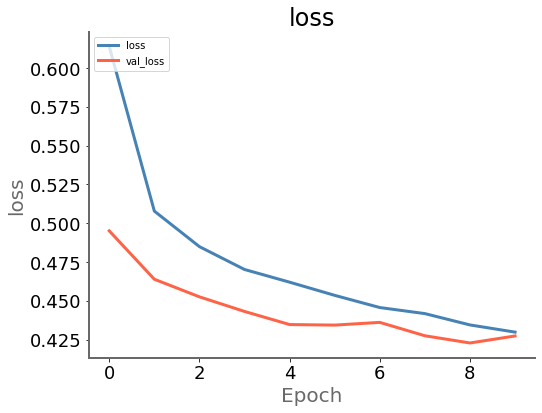

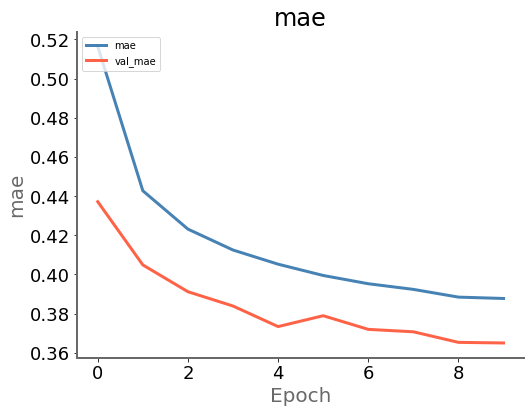

In [10]:
pwk.plot_history(history,plot={'loss':['loss','val_loss'], 'mae':['mae','val_mae']}, save_as='01-history')

## Step 5 - Predict

### 5.1 - Load model

In [11]:
loaded_model = tf.keras.models.load_model('./run/models/best_model.h5')

### 5.2 Make a prediction
A basic prediction, with normalized values (so humanly not very understandable)

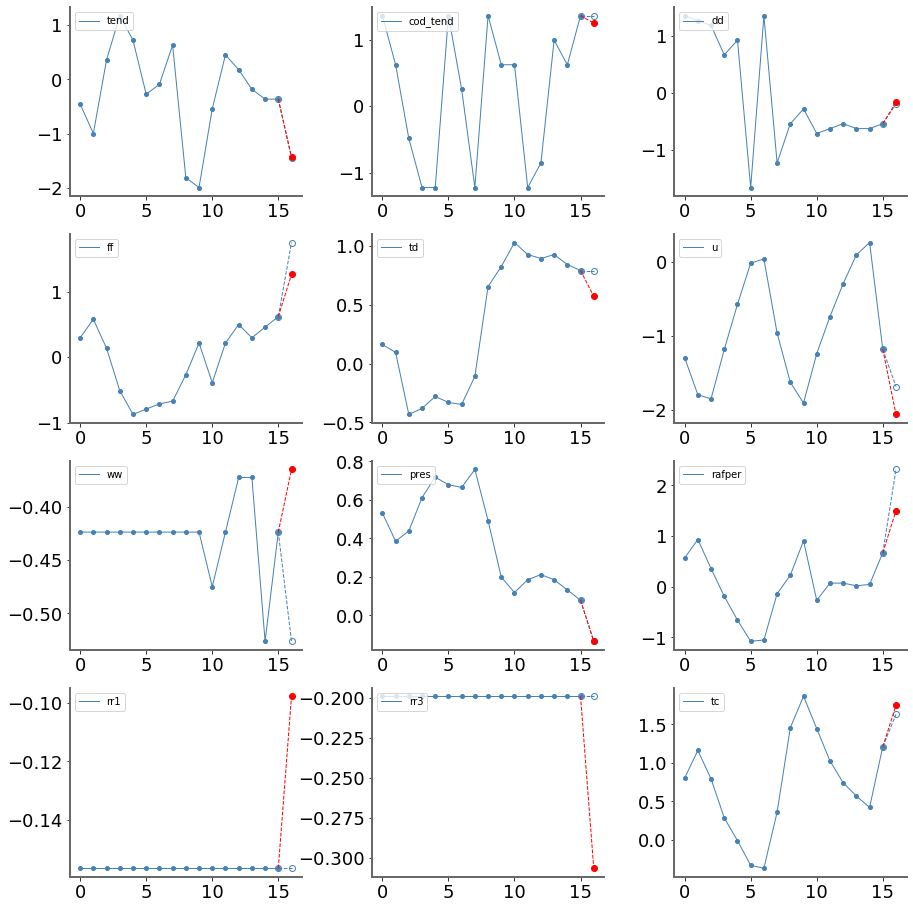

In [12]:
s=random.randint(0,len(dataset_test)-sequence_len)

sequence      = dataset_test[s:s+sequence_len]
sequence_true = dataset_test[s:s+sequence_len+1]

pred = loaded_model.predict( np.array([sequence]) )

# ---- Show result
pwk.plot_multivariate_serie(sequence_true, predictions=pred, labels=features, save_as='02-prediction-norm')


### 5.3 Real prediction
We are now going to make a true prediction, with an un-normalized result

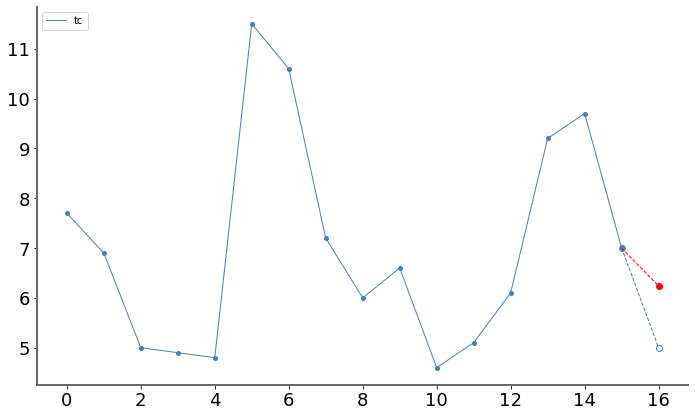

Gap between prediction and reality : 1.24 °C


In [13]:
def denormalize(mean,std,seq):
    nseq = seq.copy()
    for i,s in enumerate(nseq):
        s = s*std + mean
        nseq[i]=s
    return nseq


# ---- Get a sequence

i=random.randint(0,len(dataset_test)-sequence_len)
sequence      = dataset_test[i:i+sequence_len]
sequence_true = dataset_test[i:i+sequence_len+1]

# ---- Prediction

pred = loaded_model.predict( np.array([sequence]) )

# ---- De-normalization

sequence_true = denormalize(mean,std, sequence_true)
pred          = denormalize(mean,std, pred)

# ---- Show it
feat=11

pwk.plot_multivariate_serie(sequence_true, predictions=pred, labels=features, only_features=[feat],width=14, height=8, save_as='03-prediction')

delta_deg=abs(sequence_true[-1][feat]-pred[-1][feat])
print(f'Gap between prediction and reality : {delta_deg:.2f} °C')


In [14]:
pwk.end()

End time is : Wednesday 27 January 2021, 19:22:25
Duration is : 00:02:14 669ms
This notebook ends here


---
<img width="80px" src="../fidle/img/00-Fidle-logo-01.svg"></img>